In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/AudioProcessing/Emotion_Recognition'
%ls

/content/drive/My Drive/AudioProcessing/Emotion_Recognition
 CREMA/     kaggle.json            RAVDESS_copied/                     try/
 EMODB/     model.png              SAVEE/
 EMO_DB/   'Papers & Materials'@   speech-emotion-recognition-en.zip
 IEMOCAP/   RAVDESS/               TESS/


In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.preprocessing import  StandardScaler
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
import csv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:
csvpath = 'TESS/hand_engineered_features_TESS_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(1114, 26) (1114, 1)
(239, 26) (239, 1)
(239, 26) (239, 1)


In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename)
          
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
      spect = librosa.power_to_db(spect, ref=np.max)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('TESS/TESS_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]




max_x,max_y = findmaxsize(rslt_df)

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def extract_mel_spectrogram(df,max_x,max_y):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']

      y, sr = librosa.core.load(filename)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
      spect = librosa.power_to_db(spect, ref=np.max)

            # Adjusting the size to be 128 x 660
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)

      mel_specs.append(spect)
      labels.append(label_to_onehot(row['labels']))
  mel_specs = np.array(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels

train_path = "TESS//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv,max_x,max_y)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
X_train_spec = np.expand_dims(X_train_spec,axis=3)
print(X_train_spec.shape,Y_train_spec.shape)


test_path = "TESS//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv,max_x,max_y)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
X_test_spec = np.expand_dims(X_test_spec,axis=3)
print(X_test_spec.shape,Y_test_spec.shape)

val_path = "TESS//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv,max_x,max_y)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
X_val_spec = np.expand_dims(X_val_spec,axis=3)
print(X_val_spec.shape,Y_val_spec.shape)

# TESS Dataset download

In [ ]:
! pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 98% 419M/428M [00:05<00:00, 94.4MB/s]
100% 428M/428M [00:05<00:00, 79.6MB/s]


In [ ]:
import zipfile
path_to_zip_file = "TESS//toronto-emotional-speech-set-tess.zip"
directory_to_extract_to = "TESS"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# TESS dataset processing

In [ ]:
def decompose_tess():

        PATH = 'TESS/TESS Toronto emotional speech set data/'
        emotion = []
        path = []
        for dirname, _, filenames in os.walk(PATH):
          for name in filenames[1:]:
                    #print(dirname,dirname.split('_')[-1])
                    e = dirname.split('_')[-1]
                
                    if e == 'angry':  
                        emotion.append('angry')
                    elif e == 'disgust':  
                        emotion.append('disgust')
                    elif e == 'Fear' or e == 'fear':  
                        emotion.append('fear')
                    elif e == 'happy':  
                        emotion.append('happy')
                    elif e == 'neutral':  
                        emotion.append('neutral')
                    elif e == 'sad' or e == 'Sad' :  
                        emotion.append('sad')
                    elif e == 'surprised' or e == 'surprise':  
                        emotion.append('surprise')
                    elif e == 'calm':  
                        emotion.append('calm')
                    else:
                        print(dirname, "Error")
                        #emotion.append('m_neutral')
                

                    path.append(os.path.join(dirname,name))

        print(len(path),len(emotion))
        tess_df = pd.DataFrame(emotion, columns=['labels'])
        #emodb_df['source'] = 'EMODB'
        tess_df = pd.concat([tess_df, pd.DataFrame(path, columns=['path'])], axis=1)
        
        return tess_df

In [ ]:
df = decompose_tess()
print(df.shape)
df.to_csv('TESS/TESS_details.csv',index=False,index_label=False)

2786 2786
(2786, 2)


In [ ]:
df.head()

,labels,path
0,fear,TESS/TESS Toronto emotional speech set data/OA...
1,fear,TESS/TESS Toronto emotional speech set data/OA...
2,fear,TESS/TESS Toronto emotional speech set data/OA...
3,fear,TESS/TESS Toronto emotional speech set data/OA...
4,fear,TESS/TESS Toronto emotional speech set data/OA...


In [ ]:
#angry, happy, neutral, sad
X = pd.read_csv('TESS/TESS_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 
  
rslt_df = X[X['labels'].isin(options)] 
print(np.unique(rslt_df.labels))
print(rslt_df.shape)
rslt_df.head()

['angry' 'happy' 'neutral' 'sad']
(1592, 2)


,labels,path
398,sad,TESS/TESS Toronto emotional speech set data/OA...
399,sad,TESS/TESS Toronto emotional speech set data/OA...
400,sad,TESS/TESS Toronto emotional speech set data/OA...
401,sad,TESS/TESS Toronto emotional speech set data/OA...
402,sad,TESS/TESS Toronto emotional speech set data/OA...


In [ ]:
sizes = []
for index, row in rslt_df.iterrows(): 
    #print(row['labels'],row['path'])
    y, sr = librosa.load(row['path'], mono=True, duration=30)
    sizes.append(y.shape[0])
    
print('The max size is',max(sizes))
print('The average size is ', sum(sizes)/len(sizes))
print(sr)

The max size is 65815
The average size is  45596.97173366834
22050


In [ ]:
test_val= rslt_df.sample(frac = 0.3)
train = rslt_df.drop(test_val.index)

test= test_val.sample(frac = 0.5)
val = test_val.drop(test.index)
print(val['labels'].unique())
print(test['labels'].unique())
print(train['labels'].unique())

['happy' 'angry' 'sad' 'neutral']
['angry' 'happy' 'neutral' 'sad']
['sad' 'angry' 'happy' 'neutral']


In [ ]:
train.to_csv("TESS//train.csv")
test.to_csv("TESS//test.csv")
val.to_csv("TESS//val.csv")

# WaveNetPaper

In [ ]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(4)] * 2 
sr = 16000
# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(int(sr*time), 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))
out = AveragePooling1D(sr*time)(out)
out = Conv1D(8,1,activation='relu')(out)
out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet_paper = Model(history_seq, out)
Wavenet_paper.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 64000, 16)    32          ['input_4[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 64000, 32)    1056        ['conv1d_7[0][0]']               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 64000, 32)    1056        ['conv1d_7[0][0]']               
                                                                                            

## Trial 1

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//wavenet_paper_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//wavenet_paper_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet_paper.fit(X_train,Y_train, batch_size=12,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
93/93 [==============================] - 77s 446ms/step - loss: 1.3870 - accuracy: 0.7500 - val_loss: 1.3847 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.38472, saving model to TESS//models/wavenet_paper_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to TESS//models/wavenet_paper_acc.h5
Epoch 2/30
93/93 [==============================] - 42s 449ms/step - loss: 1.3602 - accuracy: 0.7502 - val_loss: 1.2987 - val_accuracy: 0.7615

Epoch 00002: val_loss improved from 1.38472 to 1.29867, saving model to TESS//models/wavenet_paper_loss.h5

Epoch 00002: val_accuracy improved from 0.75000 to 0.76151, saving model to TESS//models/wavenet_paper_acc.h5
Epoch 3/30
93/93 [==============================] - 42s 451ms/step - loss: 1.2494 - accuracy: 0.7675 - val_loss: 1.2175 - val_accuracy: 0.7615

Epoch 00003: val_loss improved from 1.29867 to 1.21747, saving model to TESS//models/wavenet_paper_loss.h5

Epoch 00003: val_accuracy did n

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
Wavenet_paper.load_weights('TESS//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('TESS//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

8/8 [==============================] - 8s 810ms/step - loss: 0.9409 - accuracy: 0.8110
[0.938992977142334, 0.8117154836654663]
8/8 [==============================] - 7s 809ms/step - loss: 0.9390 - accuracy: 0.8117


[0.938992977142334, 0.8117154836654663]

8/8 [==============================] - 7s 810ms/step - loss: 0.9390 - accuracy: 0.8117
(239,) (239,)
F1 SCORE: 0.5373307173340762
Kappa: 0.4188895708417921
Accuracy: 0.5690376569037657
Jaccard Score: 0.3991169741169741
Precision: 0.5975876519255128
Recall: 0.5546549716023931
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        62
           1       0.77      0.43      0.55        56
           2       0.32      0.14      0.20        57
           3       0.44      0.86      0.58        64

    accuracy                           0.57       239
   macro avg       0.60      0.55      0.54       239
weighted avg       0.60      0.57      0.54       239



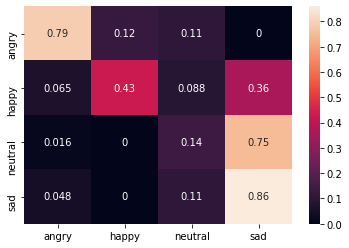

In [ ]:
Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))
cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

##Trial 2

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//wavenet_paper_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//wavenet_paper_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet_paper.fit(X_train,Y_train, batch_size=12,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
93/93 [==============================] - ETA: 0s - loss: 1.3635 - accuracy: 0.7509
Epoch 1: val_loss improved from inf to 1.29748, saving model to TESS//models/wavenet_paper_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.75628, saving model to TESS//models/wavenet_paper_acc_2.h5
93/93 [==============================] - 50s 461ms/step - loss: 1.3635 - accuracy: 0.7509 - val_loss: 1.2975 - val_accuracy: 0.7563
Epoch 2/30
93/93 [==============================] - ETA: 0s - loss: 1.2184 - accuracy: 0.7637
Epoch 2: val_loss improved from 1.29748 to 1.15973, saving model to TESS//models/wavenet_paper_loss_2.h5

Epoch 2: val_accuracy improved from 0.75628 to 0.76046, saving model to TESS//models/wavenet_paper_acc_2.h5
93/93 [==============================] - 42s 455ms/step - loss: 1.2184 - accuracy: 0.7637 - val_loss: 1.1597 - val_accuracy: 0.7605
Epoch 3/30
93/93 [==============================] - ETA: 0s - loss: 1.1219 - accuracy: 0.7695
Epoch 3: val_loss improved from 1

8/8 [==============================] - 3s 394ms/step - loss: 0.8906 - accuracy: 0.8096
(239,) (239,)
F1 SCORE: 0.5371855344592591
Kappa: 0.42402835203780265
Accuracy: 0.5732217573221757
Jaccard Score: 0.4007224236726654
Precision: 0.6128169307620667
Recall: 0.5578231743673701
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        62
           1       0.85      0.39      0.54        56
           2       0.33      0.14      0.20        57
           3       0.43      0.86      0.58        64

    accuracy                           0.57       239
   macro avg       0.61      0.56      0.54       239
weighted avg       0.61      0.57      0.54       239



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


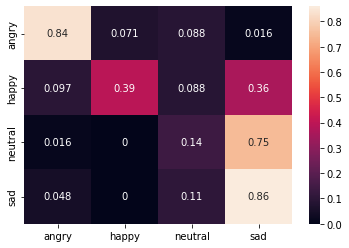

In [ ]:
Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(X_test.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))
cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(X_test.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Trial 3

8/8 [==============================] - 3s 394ms/step - loss: 0.8910 - accuracy: 0.8086
(239,) (239,)
F1 SCORE: 0.47843914543363797
Kappa: 0.3971629564492989
Accuracy: 0.5439330543933054
Jaccard Score: 0.36432748538011694
Precision: 0.5139311126813797
Recall: 0.5535057401568437
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        62
           1       0.85      0.39      0.54        56
           2       0.37      0.98      0.54        57
           3       0.00      0.00      0.00        64

    accuracy                           0.54       239
   macro avg       0.51      0.55      0.48       239
weighted avg       0.50      0.54      0.47       239



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

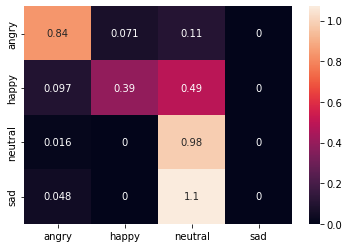

In [ ]:
Wavenet_paper.load_weights('TESS//models//wavenet_paper_loss_2.h5')
Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(X_test.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))
cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(X_test.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Trial 4

8/8 [==============================] - 3s 391ms/step - loss: 0.9032 - accuracy: 0.8107
(239,) (239,)
F1 SCORE: 0.48455171530399266
Kappa: 0.4027764923646461
Accuracy: 0.5481171548117155
Jaccard Score: 0.3710371880405239
Precision: 0.5187929488494031
Recall: 0.5579700258711294
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        62
           1       0.85      0.41      0.55        56
           2       0.37      0.98      0.54        57
           3       0.00      0.00      0.00        64

    accuracy                           0.55       239
   macro avg       0.52      0.56      0.48       239
weighted avg       0.51      0.55      0.48       239



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

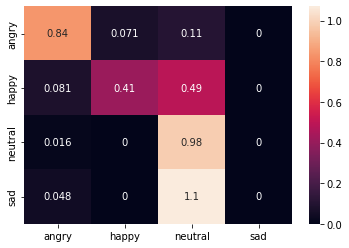

In [ ]:
Wavenet_paper.load_weights('TESS//models//wavenet_paper_acc_2.h5')
Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(X_test.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))
cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(X_test.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Wavenet 5

In [ ]:
# hyper-parameters

def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention

n_filters = 64
filter_width = 2
dilation_rates = [2**i for i in range(3)]  
sr = 16000

history_seq = Input(shape=(int(sr*time), 1))
x = history_seq


x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)
skips = []
for dilation_rate in dilation_rates:
    
    
    x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    
    skips.append(z)


out = Activation('relu')(Add()(skips))

out = AveragePooling1D(8000)(out)
out = self_attention(out)

out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet5 = Model(history_seq, out)
Wavenet5.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, 64000, 8)     48          input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 64000, 8)     0           conv1d_77[0][0]                  
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, 64000, 8)     328         leaky_re_lu_14[0][0]             
____________________________________________________________________________________________

In [ ]:
Wavenet5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//wavenet5_loss_1.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//wavenet5_acc_1.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet5.fit(X_train,Y_train, batch_size=12,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
93/93 [==============================] - 19s 182ms/step - loss: 1.3863 - accuracy: 0.7500 - val_loss: 1.3889 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.38887, saving model to TESS//models/wavenet5_loss_1.h5

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to TESS//models/wavenet5_acc_1.h5
Epoch 2/30
93/93 [==============================] - 16s 175ms/step - loss: 1.3874 - accuracy: 0.7500 - val_loss: 1.3773 - val_accuracy: 0.7500

Epoch 00002: val_loss improved from 1.38887 to 1.37730, saving model to TESS//models/wavenet5_loss_1.h5

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/30
93/93 [==============================] - 16s 172ms/step - loss: 1.2867 - accuracy: 0.7537 - val_loss: 1.1317 - val_accuracy: 0.7824

Epoch 00003: val_loss improved from 1.37730 to 1.13171, saving model to TESS//models/wavenet5_loss_1.h5

Epoch 00003: val_accuracy improved from 0.75000 to 0.78243, saving model to TESS//models/wavenet5_

In [ ]:
Wavenet5.load_weights('TESS//models//wavenet5_loss_1.h5')
print(Wavenet5.evaluate(X_test,Y_test))
Wavenet5.load_weights('TESS//models//wavenet5_acc_1.h5')
Wavenet5.evaluate(X_test,Y_test)

8/8 [==============================] - 1s 154ms/step - loss: 0.0429 - accuracy: 0.9937
[0.04285595938563347, 0.9937238693237305]
8/8 [==============================] - 1s 145ms/step - loss: 0.0429 - accuracy: 0.9937


[0.04285595938563347, 0.9937238693237305]

8/8 [==============================] - 1s 146ms/step - loss: 0.0545 - accuracy: 0.9937
(239,) (239,)
F1 SCORE: 0.987440122044241
Kappa: 0.9832550970363624
Accuracy: 0.9874476987447699
Jaccard Score: 0.9753502155172414
Precision: 0.9870689655172414
Recall: 0.98828125


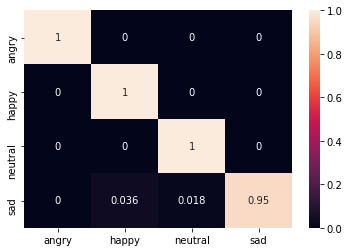

In [ ]:


Wavenet5.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet5.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet5.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Hand Engineered

In [ ]:
def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "TESS//train.csv"
test_csv = "TESS//test.csv"
val_csv = "TESS//val.csv"
csvpath = 'TESS//hand_engineered_features_EMODB_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'TESS//hand_engineered_features_EMODB_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'TESS//hand_engineered_features_EMODB_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'TESS/hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(1114, 26) (1114, 1)
(239, 26) (239, 1)
(239, 26) (239, 1)


In [ ]:
ann_model = Sequential(name='Input_Layer')
ann_model.add(Dense(256,name='Dense_1'))
ann_model.add(LeakyReLU(name='Leaky_Relu_Activation_1'))
ann_model.add(Dense(64,name='Dense_2'))
ann_model.add(LeakyReLU(name = 'LEaky_Relu_Activation_2'))
ann_model.add(Dense(4, activation='softmax',name='Output_Layer'))

ann_model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann_model.fit(X_train_features,
          Y_train_features,
          epochs=30,
          batch_size=16,
          validation_data=(X_val_features, Y_val_features))

Epoch 1/30
70/70 [==============================] - 1s 6ms/step - loss: 0.5814 - accuracy: 0.8398 - val_loss: 0.0709 - val_accuracy: 0.9833
Epoch 2/30
70/70 [==============================] - 0s 4ms/step - loss: 0.0361 - accuracy: 0.9955 - val_loss: 0.0411 - val_accuracy: 0.9916
Epoch 3/30
70/70 [==============================] - 0s 4ms/step - loss: 0.0162 - accuracy: 0.9986 - val_loss: 0.0398 - val_accuracy: 0.9916
Epoch 4/30
70/70 [==============================] - 0s 4ms/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 0.0345 - val_accuracy: 0.9916
Epoch 5/30
70/70 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0335 - val_accuracy: 0.9916
Epoch 6/30
70/70 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.0269 - val_accuracy: 0.9916
Epoch 7/30
70/70 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9916
Epoch 8/30
70/70 [==

In [ ]:
ann_model.load_weights('TESS//models//ANN_loss.h5')
print(ann_model.evaluate(X_test_features,Y_test_features))
ann_model.load_weights('TESS//models//ANN_acc.h5')
ann_model.evaluate(X_test_features,Y_test_features)

8/8 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9958
[0.023911790922284126, 0.9958158731460571]
8/8 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9916


[0.02638118341565132, 0.991631805896759]

8/8 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9916
[0.02638118341565132, 0.991631805896759]
F1 SCORE: 0.9917077850877193
Kappa: 0.9888307318440975
Accuracy: 0.9916317991631799
Jaccard Score: 0.98368700265252
Precision: 0.9917077850877193
Recall: 0.9917077850877193


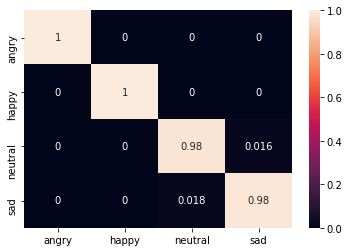

In [ ]:

ann_model.load_weights('TESS//models//ANN_acc.h5')
ann_model.evaluate(X_test_features,Y_test_features)

print(ann_model.evaluate(X_test_features,Y_test_features))
g = Y_test_features
p = np.argmax(ann_model.predict(X_test_features),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(ann_model.predict(X_test_features),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Ensembled

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_83 (Conv1D)             (None, 64000, 8)     48          ['input_9[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 64000, 8)     0           ['conv1d_83[0][0]']              
                                                                                                  
 conv1d_84 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_16[0][0]']         
                                                                                            

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//ensembled_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//ensembled_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
70/70 [==============================] - 11s 117ms/step - loss: 1.0285 - accuracy: 0.6922 - val_loss: 0.2685 - val_accuracy: 0.9665

Epoch 00001: val_loss improved from inf to 0.26853, saving model to TESS//models/ensembled_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.96653, saving model to TESS//models/ensembled_acc.h5
Epoch 2/30
70/70 [==============================] - 8s 111ms/step - loss: 0.1796 - accuracy: 0.9823 - val_loss: 0.0890 - val_accuracy: 0.9791

Epoch 00002: val_loss improved from 0.26853 to 0.08896, saving model to TESS//models/ensembled_loss.h5

Epoch 00002: val_accuracy improved from 0.96653 to 0.97908, saving model to TESS//models/ensembled_acc.h5
Epoch 3/30
70/70 [==============================] - 8s 111ms/step - loss: 0.0628 - accuracy: 0.9897 - val_loss: 0.0595 - val_accuracy: 0.9916

Epoch 00003: val_loss improved from 0.08896 to 0.05954, saving model to TESS//models/ensembled_loss.h5

Epoch 00003: val_accuracy improved from 0.97908 to 0.

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

ensembled.load_weights("TESS//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("TESS//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

8/8 [==============================] - 3s 183ms/step - loss: 0.0088 - accuracy: 0.9986
[0.021812191233038902, 0.9958158731460571]
8/8 [==============================] - 1s 147ms/step - loss: 0.0389 - accuracy: 0.9874


[0.03890075162053108, 0.9874476790428162]

8/8 [==============================] - 1s 155ms/step - loss: 0.0218 - accuracy: 0.9958
[0.021812191233038902, 0.9958158731460571]
F1 SCORE: 0.9958575830195139
Kappa: 0.9944162792327641
Accuracy: 0.99581589958159
Jaccard Score: 0.9917834051724138
Precision: 0.9956896551724138
Recall: 0.99609375


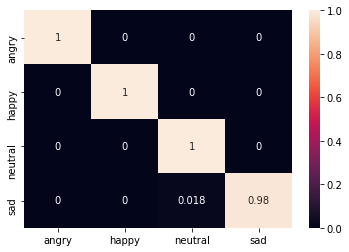

In [ ]:
ensembled.load_weights("TESS//models/ensembled_loss.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Trial 2

8/8 [==============================] - 2s 98ms/step - loss: 0.0389 - accuracy: 0.9874
[0.038900747895240784, 0.9874476790428162]
F1 SCORE: 0.987548878370035
Kappa: 0.9832433569375307
Accuracy: 0.9874476987447699
Jaccard Score: 0.975705329153605
Precision: 0.9878434065934066
Recall: 0.9873218201754386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


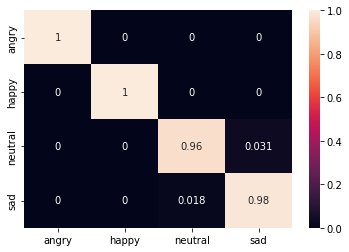

In [ ]:
ensembled.load_weights("TESS//models/ensembled_acc.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Trial 3

In [ ]:
model_checkpoint1 = ModelCheckpoint('TESS//models//ensembled_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//ensembled_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
70/70 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.8483
Epoch 1: val_loss improved from inf to 0.29269, saving model to TESS//models/ensembled_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.96653, saving model to TESS//models/ensembled_acc_2.h5
70/70 [==============================] - 65s 140ms/step - loss: 0.7388 - accuracy: 0.8483 - val_loss: 0.2927 - val_accuracy: 0.9665
Epoch 2/30
70/70 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9883
Epoch 2: val_loss improved from 0.29269 to 0.08948, saving model to TESS//models/ensembled_loss_2.h5

Epoch 2: val_accuracy improved from 0.96653 to 0.97908, saving model to TESS//models/ensembled_acc_2.h5
70/70 [==============================] - 8s 118ms/step - loss: 0.1349 - accuracy: 0.9883 - val_loss: 0.0895 - val_accuracy: 0.9791
Epoch 3/30
70/70 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9937
Epoch 3: val_loss improved from 0.08948 to 0.05593

8/8 [==============================] - 1s 84ms/step - loss: 0.0278 - accuracy: 0.9958
[0.02779996581375599, 0.9958158731460571]
F1 SCORE: 0.9958575830195139
Kappa: 0.9944162792327641
Accuracy: 0.99581589958159
Jaccard Score: 0.9917834051724138
Precision: 0.9956896551724138
Recall: 0.99609375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


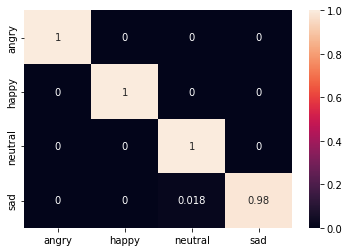

In [ ]:
#ensembled.load_weights("TESS//models/ensembled_acc_2.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Trial 4

8/8 [==============================] - 1s 83ms/step - loss: 0.0308 - accuracy: 0.9916
[0.03083842620253563, 0.991631805896759]
F1 SCORE: 0.9917077850877193
Kappa: 0.9888307318440975
Accuracy: 0.9916317991631799
Jaccard Score: 0.98368700265252
Precision: 0.9917077850877193
Recall: 0.9917077850877193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


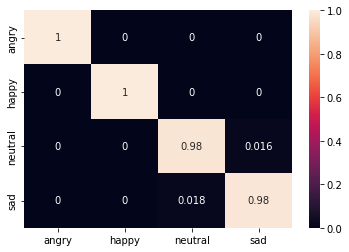

In [ ]:
ensembled.load_weights("TESS//models/ensembled_acc_2.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

8/8 [==============================] - 1s 80ms/step - loss: 0.0290 - accuracy: 0.9958
[0.02900487184524536, 0.9958158731460571]
F1 SCORE: 0.9958575830195139
Kappa: 0.9944162792327641
Accuracy: 0.99581589958159
Jaccard Score: 0.9917834051724138
Precision: 0.9956896551724138
Recall: 0.99609375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


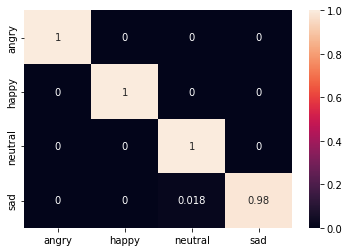

In [ ]:
ensembled.load_weights("TESS//models/ensembled_loss_2.h5")
#test set

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# CNN

In [ ]:
cnn_model = Sequential(name='Convolutional_Neural_Network')

cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     input_shape=(max_x,max_y,1),name = "Input_Convolution_Layer"))
cnn_model.add(LeakyReLU( name = "Leaky_Relu_Activation_1"))
# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4),name = 'Max_Pooling_1'))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),name = "Convolution_Layer_2"
                     ))
cnn_model.add(LeakyReLU(name = "Leaky_Relu_Activation_2"))
# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4),name = 'Max_Pooling_2'))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten(name = 'Flatten'))

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64,name = 'Dense_1' ))
cnn_model.add(LeakyReLU())

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25,name = 'Dropout'))

# Adding an output layer
cnn_model.add(Dense(4, activation='softmax',name = 'Output_Layer'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(f'TESS//models//CNN.h5', monitor='val_loss',verbose=1, save_best_only=True)
# Fitting our neural network
history = cnn_model.fit(X_train_spec,
                        Y_train_spec, 
                        batch_size=16,
                        validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = model_checkpoint)

Epoch 1/30
70/70 [==============================] - 1s 7ms/step - loss: 0.9154 - accuracy: 0.6153 - val_loss: 0.1867 - val_accuracy: 0.9205

Epoch 00001: val_loss improved from inf to 0.18670, saving model to TESS//models/CNN.h5
Epoch 2/30
70/70 [==============================] - 0s 5ms/step - loss: 0.1905 - accuracy: 0.9193 - val_loss: 0.0613 - val_accuracy: 0.9791

Epoch 00002: val_loss improved from 0.18670 to 0.06125, saving model to TESS//models/CNN.h5
Epoch 3/30
70/70 [==============================] - 0s 5ms/step - loss: 0.0578 - accuracy: 0.9830 - val_loss: 0.0464 - val_accuracy: 0.9791

Epoch 00003: val_loss improved from 0.06125 to 0.04639, saving model to TESS//models/CNN.h5
Epoch 4/30
70/70 [==============================] - 0s 5ms/step - loss: 0.0290 - accuracy: 0.9910 - val_loss: 0.0310 - val_accuracy: 0.9874

Epoch 00004: val_loss improved from 0.04639 to 0.03102, saving model to TESS//models/CNN.h5
Epoch 5/30
70/70 [==============================] - 0s 5ms/step - loss: 

In [ ]:
cnn_model.load_weights('TESS//models//CNN.h5')
cnn_model.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.9874


[0.027469299733638763, 0.9874476790428162]

F1 SCORE: 0.9957550902942658
Kappa: 0.9944161487780945
Accuracy: 0.99581589958159
Jaccard Score: 0.9915817770232032
Precision: 0.9956140350877193
Recall: 0.9959677419354839


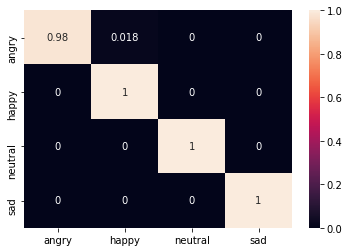

In [ ]:
#test set

g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(cnn_model.predict(X_test_spec),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(cnn_model.predict(X_test_spec),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Paper_1

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 8
srk = 44100
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 352800, 1) (1114, 4)
Test Data (239, 352800, 1) (239, 4)
Val Data (239, 352800, 1) (239, 4)


In [ ]:
def paper_model():
  inp = Input((352800,1))
  l1 = BatchNormalization()(Conv1D(32,21,activation='relu',padding = 'same')(inp))
  m1 = MaxPool1D(2)(l1)

  l2 = BatchNormalization()(Conv1D(64,19,activation='relu',padding = 'same')(m1))
  m2 = MaxPool1D(2)(l2)

  l3 = BatchNormalization()(Conv1D(128,17,activation='relu',padding = 'same')(m2))
  m3 = MaxPool1D(2)(l3)


  l4 = BatchNormalization()(Conv1D(256,15,activation='relu',padding = 'same')(m3))
  m4 = MaxPool1D(2)(l4)

  l5 = BatchNormalization()(Conv1D(512,13,activation='relu',padding = 'same')(m4))
  m5 = MaxPool1D(2)(l5)

  l6 = BatchNormalization()(Conv1D(1024,11,activation='relu',padding = 'same')(m5))
  m6 = MaxPool1D(2)(l6)

  l7 = BatchNormalization()(Conv1D(1024,9,activation='relu',padding = 'same')(m6))
  m7 = GlobalMaxPool1D()(l7)

  fl = Flatten()(m7)
  d1 = Dense(128,activation='relu')(fl)
  out = Dense(4,activation='softmax')(d1)

  return Model(inputs = inp,outputs = out)

m = paper_model()
m.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 352800, 1)]       0         
                                                                 
 conv1d (Conv1D)             (None, 352800, 32)        704       
                                                                 
 batch_normalization (BatchN  (None, 352800, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 176400, 32)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 176400, 64)        38976     
                                                                 
 batch_normalization_1 (Batc  (None, 176400, 64)       256 

## Trial 1



In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_1_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_1_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = m.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - 463s 3s/step - loss: 3.6194 - accuracy: 0.4833 - val_loss: 2.8061 - val_accuracy: 0.0251

Epoch 00001: val_loss improved from inf to 2.80608, saving model to TESS//models/paper_1_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.02510, saving model to TESS//models/paper_1_acc.h5
Epoch 2/30
140/140 [==============================] - 458s 3s/step - loss: 1.1805 - accuracy: 0.6726 - val_loss: 3.6209 - val_accuracy: 0.2385

Epoch 00002: val_loss did not improve from 2.80608

Epoch 00002: val_accuracy improved from 0.02510 to 0.23849, saving model to TESS//models/paper_1_acc.h5
Epoch 3/30
140/140 [==============================] - 456s 3s/step - loss: 0.1924 - accuracy: 0.9388 - val_loss: 1.9987 - val_accuracy: 0.5565

Epoch 00003: val_loss improved from 2.80608 to 1.99872, saving model to TESS//models/paper_1_loss.h5

Epoch 00003: val_accuracy improved from 0.23849 to 0.55649, saving model to TESS//models/paper_1_acc.h5
Epoch 4

In [ ]:
m.load_weights('TESS//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('TESS//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

8/8 [==============================] - 14s 2s/step - loss: 0.0179 - accuracy: 0.9916
[0.017868367955088615, 0.991631805896759]
8/8 [==============================] - 14s 2s/step - loss: 0.0179 - accuracy: 0.9916


[0.017868367955088615, 0.991631805896759]

F1 SCORE: 0.9916675847042694
Kappa: 0.9888304708493983
Accuracy: 0.9916317991631799
Jaccard Score: 0.9835330617658204
Precision: 0.9917834051724138
Recall: 0.9916294642857143
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      0.98      0.99        56
           2       0.98      1.00      0.99        57
           3       0.98      0.98      0.98        64

    accuracy                           0.99       239
   macro avg       0.99      0.99      0.99       239
weighted avg       0.99      0.99      0.99       239



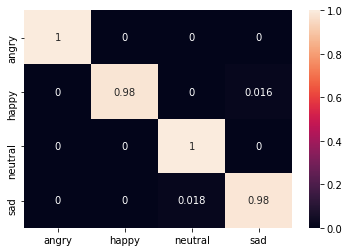

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_1_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_1_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = m.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 2.5032 - accuracy: 0.4713
Epoch 1: val_loss improved from inf to 6.49118, saving model to TESS//models/paper_1_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.24686, saving model to TESS//models/paper_1_acc_2.h5
140/140 [==============================] - 468s 3s/step - loss: 2.5032 - accuracy: 0.4713 - val_loss: 6.4912 - val_accuracy: 0.2469
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.8016 - accuracy: 0.7549
Epoch 2: val_loss improved from 6.49118 to 4.38487, saving model to TESS//models/paper_1_loss_2.h5

Epoch 2: val_accuracy did not improve from 0.24686
140/140 [==============================] - 438s 3s/step - loss: 0.8016 - accuracy: 0.7549 - val_loss: 4.3849 - val_accuracy: 0.2469
Epoch 3/30
 99/140 [====================>.........] - ETA: 1:59 - loss: 0.5300 - accuracy: 0.8699

KeyboardInterrupt: ignored

In [ ]:
m.load_weights('TESS//models//paper_1_acc_2.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('TESS//models//paper_1_loss_2.h5')
m.evaluate(X_test,Y_test)

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Plot for Trial 2

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Paper_2

In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('TESS/TESS_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]

max_x,max_y = findmaxsize(rslt_df)

KeyboardInterrupt: ignored

In [ ]:
max_x = 64
max_y = 299
T = 80
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

299 80 320 4


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "TESS//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "TESS//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "TESS//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(1114, 4, 64, 80, 3) (1114, 4)
(239, 4, 64, 80, 3) (239, 4)
(239, 4, 64, 80, 3) (239, 4)


In [ ]:
import keras
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Reshape((36,256))(X)

    X= LSTM(256,return_sequences=True)(X)
    X= LSTM(256)(X)

    
    #X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    #X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    

    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    return model

def paper_2():
    input_layer = Input((int(max_y/T)+1,max_x,T,3))
    alex = AlexNet((227,227,3))
    
    for i in range(int(max_y/T)+1):
      #print(input_layer[:,0,:,:,:].shape)
      inp = Resizing(227,227)(input_layer[:,i,:,:,:])
      
      cnn = alex(inp)

      #cnn = Reshape((1,4096))(cnn)

      if i == 0:
        output_layers = cnn
      else:
        output_layers = Concatenate(axis = 1)([output_layers,cnn])
      
    
    #print(len(output_layers))
    #lstm = LSTM(256,return_sequences=True)(output_layers)
    #lstm = LSTM(256,return_sequences=True)(lstm)
    #lstm = LSTM(256)(lstm)
    
    out = Dense(4,activation='softmax')(output_layers)
    
    
    
    return Model(inputs=input_layer,outputs=out)
p2 = paper_2()
p2.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 4, 64, 80,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_8 (Sl  (None, 64, 80, 3)   0           ['input_8[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_9 (Sl  (None, 64, 80, 3)   0           ['input_8[0][0]']                
 icingOpLambda)                                                                             

## Trial 1

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_2_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_2_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p2.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - 55s 98ms/step - loss: 1.0231 - accuracy: 0.5912 - val_loss: 0.9509 - val_accuracy: 0.6025

Epoch 00001: val_loss improved from inf to 0.95087, saving model to TESS//models/paper_2_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.60251, saving model to TESS//models/paper_2_acc.h5
Epoch 2/30
140/140 [==============================] - 10s 72ms/step - loss: 0.7640 - accuracy: 0.6988 - val_loss: 2.0006 - val_accuracy: 0.4393

Epoch 00002: val_loss did not improve from 0.95087

Epoch 00002: val_accuracy did not improve from 0.60251
Epoch 3/30
140/140 [==============================] - 10s 72ms/step - loss: 0.5203 - accuracy: 0.8076 - val_loss: 0.5777 - val_accuracy: 0.7699

Epoch 00003: val_loss improved from 0.95087 to 0.57773, saving model to TESS//models/paper_2_loss.h5

Epoch 00003: val_accuracy improved from 0.60251 to 0.76987, saving model to TESS//models/paper_2_acc.h5
Epoch 4/30
140/140 [==============================] -

In [ ]:
p2.load_weights('TESS//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('TESS//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 1s 105ms/step - loss: 0.1269 - accuracy: 0.9623
[0.12693879008293152, 0.9623430967330933]
8/8 [==============================] - 1s 60ms/step - loss: 0.0647 - accuracy: 0.9791


[0.06467041373252869, 0.9790794849395752]

F1 SCORE: 0.9621795908626358
Kappa: 0.9497253710412528
Accuracy: 0.9623430962343096
Jaccard Score: 0.9271585344848797
Precision: 0.9652173913043479
Recall: 0.961941143180532
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        62
           1       0.93      1.00      0.97        56
           2       1.00      0.91      0.95        57
           3       0.93      1.00      0.96        64

    accuracy                           0.96       239
   macro avg       0.97      0.96      0.96       239
weighted avg       0.96      0.96      0.96       239



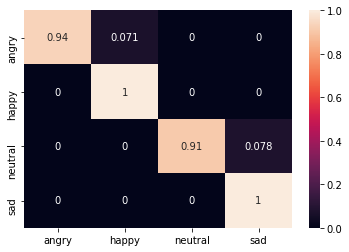

In [ ]:
#test set
p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9791796763488438
Kappa: 0.9720774820665
Accuracy: 0.9790794979079498
Jaccard Score: 0.9593656929126531
Precision: 0.9792573040464063
Recall: 0.9791789832444013
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        62
           1       0.96      0.98      0.97        56
           2       1.00      0.98      0.99        57
           3       0.98      0.98      0.98        64

    accuracy                           0.98       239
   macro avg       0.98      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239



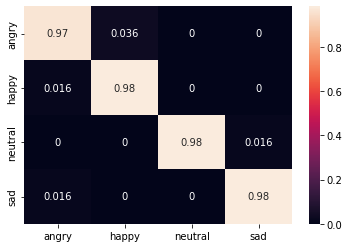

In [ ]:
#test set
p2.load_weights('TESS//models//paper_2_loss.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 3

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_2_loss_3.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_2_acc_3.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p2.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 0.8934 - accuracy: 0.5871
Epoch 1: val_loss improved from inf to 3.83024, saving model to TESS//models/paper_2_loss_3.h5

Epoch 1: val_accuracy improved from -inf to 0.30962, saving model to TESS//models/paper_2_acc_3.h5
140/140 [==============================] - 61s 314ms/step - loss: 0.8934 - accuracy: 0.5871 - val_loss: 3.8302 - val_accuracy: 0.3096
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.6840
Epoch 2: val_loss improved from 3.83024 to 2.20731, saving model to TESS//models/paper_2_loss_3.h5

Epoch 2: val_accuracy did not improve from 0.30962
140/140 [==============================] - 37s 265ms/step - loss: 0.7696 - accuracy: 0.6840 - val_loss: 2.2073 - val_accuracy: 0.3096
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.7540
Epoch 3: val_loss did not improve from 2.20731

Epoch 3: val_accuracy did not improve from 0.30962

In [ ]:
p2.load_weights('TESS//models//paper_2_acc_3.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('TESS//models//paper_2_loss_3.h5')
p2.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 1s 161ms/step - loss: 0.1113 - accuracy: 0.9540
[0.11134571582078934, 0.9539749026298523]
8/8 [==============================] - 1s 155ms/step - loss: 0.0602 - accuracy: 0.9791


[0.060210924595594406, 0.9790794849395752]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9789548313223577
Kappa: 0.9720716088622978
Accuracy: 0.9790794979079498
Jaccard Score: 0.9588165162121605
Precision: 0.9795539519439433
Recall: 0.9786992683321206
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        62
           1       0.96      0.98      0.97        56
           2       1.00      0.96      0.98        57
           3       0.97      1.00      0.98        64

    accuracy                           0.98       239
   macro avg       0.98      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239



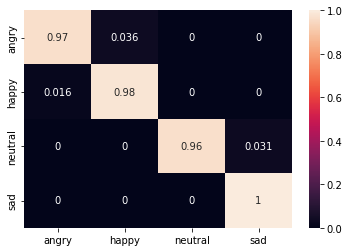

In [ ]:
#test set
p2.load_weights('TESS//models//paper_2_loss_3.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9539396550838082
Kappa: 0.9385977204783259
Accuracy: 0.9539748953974896
Jaccard Score: 0.911964872660335
Precision: 0.9536317152802773
Recall: 0.9545777245533188
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        62
           1       0.95      0.96      0.96        56
           2       0.93      0.96      0.95        57
           3       0.97      0.94      0.95        64

    accuracy                           0.95       239
   macro avg       0.95      0.95      0.95       239
weighted avg       0.95      0.95      0.95       239



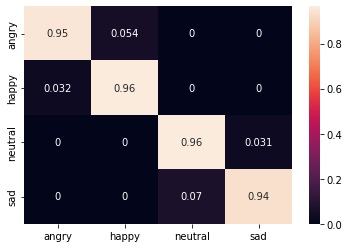

In [ ]:
#test set
p2.load_weights('TESS//models//paper_2_acc_3.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Plotting Trial

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


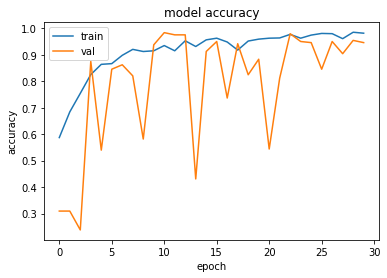

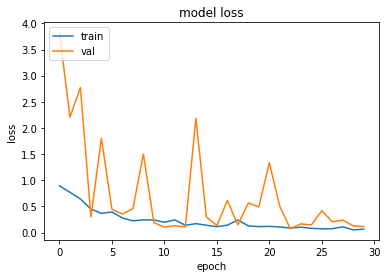

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Paper_3

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:
def paper_3():
  inp =  Input((time*16000,1))
  l1 = Conv1D(64,80,strides = 4,padding = 'same')(inp)
  m1 = MaxPooling1D(4)(l1)

  l2 = Conv1D(128,3,strides = 1,padding = 'same')(m1)
  l2 = Conv1D(128,3,strides = 1,padding = 'same')(l2)
  m2 = MaxPooling1D(4)(l2)

  l3 = Conv1D(256,3,strides = 1,padding = 'same')(m2)
  l3 = Conv1D(256,3,strides = 1,padding = 'same')(l3)
  m3 = MaxPooling1D(4)(l3)

  l4 = Conv1D(512,3,strides = 1,padding = 'same')(m3)
  l4 = Conv1D(512,3,strides = 1,padding = 'same')(l4)
  m4 = GlobalAveragePooling1D()(l4)

  f1 = Dense(1024)(m4)
  f2 = Dense(4, activation='softmax')(f1)

  return Model(inputs= inp,outputs=f2)

p3 = paper_3()
p3.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 16000, 64)         5184      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4000, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4000, 128)         24704     
                                                                 
 conv1d_2 (Conv1D)           (None, 4000, 128)         49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1000, 128)        0         
 1D)                                                         

## Trial 1

In [ ]:
p3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_3_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_3_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p3.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - 5s 31ms/step - loss: 1.2432 - accuracy: 0.3747 - val_loss: 0.8509 - val_accuracy: 0.4686

Epoch 00001: val_loss improved from inf to 0.85094, saving model to TESS//models/paper_3_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.46862, saving model to TESS//models/paper_3_acc.h5
Epoch 2/30
140/140 [==============================] - 4s 29ms/step - loss: 0.8484 - accuracy: 0.5333 - val_loss: 0.7623 - val_accuracy: 0.4770

Epoch 00002: val_loss improved from 0.85094 to 0.76227, saving model to TESS//models/paper_3_loss.h5

Epoch 00002: val_accuracy improved from 0.46862 to 0.47699, saving model to TESS//models/paper_3_acc.h5
Epoch 3/30
140/140 [==============================] - 4s 30ms/step - loss: 0.7864 - accuracy: 0.5744 - val_loss: 0.5283 - val_accuracy: 0.8033

Epoch 00003: val_loss improved from 0.76227 to 0.52831, saving model to TESS//models/paper_3_loss.h5

Epoch 00003: val_accuracy improved from 0.47699 to 0.80335, s

In [ ]:
p3.save_weights('TESS//models//paper_3_acc.h5')
#p3.load_weights('TESS//models//paper_3_acc.h5')
#print(p3.evaluate(X_test,Y_test))
#p3.load_weights('TESS//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

8/8 [==============================] - 0s 40ms/step - loss: 0.0514 - accuracy: 0.9791


[0.05138617381453514, 0.9790794849395752]

F1 SCORE: 0.978915324369134
Kappa: 0.9720709561315353
Accuracy: 0.9790794979079498
Jaccard Score: 0.958892136296855
Precision: 0.9793973103399333
Recall: 0.9786209475301156
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        62
           1       0.96      0.96      0.96        56
           2       1.00      0.98      0.99        57
           3       0.97      1.00      0.98        64

    accuracy                           0.98       239
   macro avg       0.98      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239



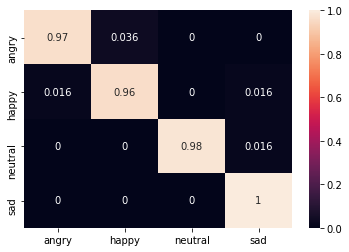

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

In [ ]:
p3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_3_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_3_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p3.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 1.0257 - accuracy: 0.4587
Epoch 1: val_loss improved from inf to 0.74685, saving model to TESS//models/paper_3_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.58996, saving model to TESS//models/paper_3_acc_2.h5
140/140 [==============================] - 12s 68ms/step - loss: 1.0257 - accuracy: 0.4587 - val_loss: 0.7469 - val_accuracy: 0.5900
Epoch 2/30
139/140 [============================>.] - ETA: 0s - loss: 1.1056 - accuracy: 0.4874
Epoch 2: val_loss improved from 0.74685 to 0.73310, saving model to TESS//models/paper_3_loss_2.h5

Epoch 2: val_accuracy improved from 0.58996 to 0.59414, saving model to TESS//models/paper_3_acc_2.h5
140/140 [==============================] - 9s 62ms/step - loss: 1.1056 - accuracy: 0.4874 - val_loss: 0.7331 - val_accuracy: 0.5941
Epoch 3/30
139/140 [============================>.] - ETA: 0s - loss: 0.8302 - accuracy: 0.5692
Epoch 3: val_loss did not improve from 0.73310

Ep

In [ ]:
p3.evaluate(X_test,Y_test)
p3.save_weights('TESS//models//paper_3_2.h5')

8/8 [==============================] - 1s 82ms/step - loss: 0.2365 - accuracy: 0.9289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9271069472201696
Kappa: 0.9048678264534408
Accuracy: 0.9288702928870293
Jaccard Score: 0.8674412114305321
Precision: 0.940253159003159
Recall: 0.9252538478252081
              precision    recall  f1-score   support

           0       0.82      0.98      0.90        62
           1       1.00      0.77      0.87        56
           2       0.98      0.96      0.97        57
           3       0.95      0.98      0.97        64

    accuracy                           0.93       239
   macro avg       0.94      0.93      0.93       239
weighted avg       0.94      0.93      0.93       239



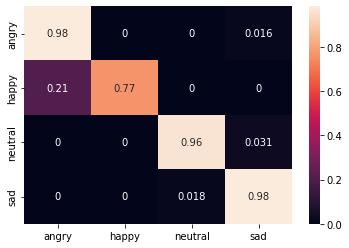

In [ ]:
#test set
p3.load_weights('TESS//models//paper_3_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9957550902942658
Kappa: 0.9944161487780945
Accuracy: 0.99581589958159
Jaccard Score: 0.9915817770232032
Precision: 0.9956140350877193
Recall: 0.9959677419354839
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       0.98      1.00      0.99        56
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        64

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239



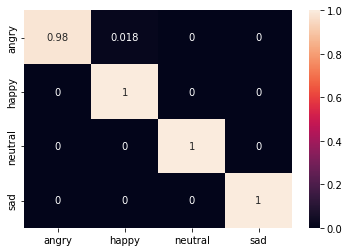

In [ ]:
#test set
p3.load_weights('TESS//models//paper_3_loss_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9829725829725829
Kappa: 0.9776551982049364
Accuracy: 0.9832635983263598
Jaccard Score: 0.9670715249662618
Precision: 0.9836516203703703
Recall: 0.9825748847926268
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        62
           1       0.98      0.95      0.96        56
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        64

    accuracy                           0.98       239
   macro avg       0.98      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239



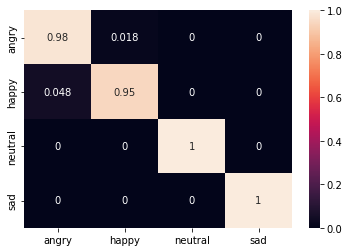

In [ ]:
#test set
p3.load_weights('TESS//models//paper_3_acc_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# paper 4

In [ ]:
!pip install Signal_Analysis

     |████████████████████████████████| 378 kB 5.4 MB/s 
  Created wheel for Signal-Analysis: filename=Signal_Analysis-0.1.26-py3-none-any.whl size=14531 sha256=932f86e82c2d07d834f8a7a9e7fef9ba5bd1dc67623d550765dcf78179cf6f51
  Stored in directory: /root/.cache/pip/wheels/72/da/25/128af0db67fe61f8282e790d94387346357c063d72522661d6
Successfully built Signal-Analysis


In [ ]:
import numpy as np
import pandas as pd

import ast
import os
from tqdm.notebook import tqdm
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sound Processing
import librosa
from Signal_Analysis.features.signal import get_F_0, get_HNR

# Training Data Preparation
from sklearn.model_selection import train_test_split



import tensorflow as tf
#from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
import numpy as np
import librosa.display
import IPython.display as ipd

In [ ]:
NUM_EMOTIONS = 4
N_FFT = 4096
HOP_LENGTH = 1024
EMOTIONS = ['ang', 'hap', 'neu', 'sad']
SR = 16000


def extract_HSF(lld):
    mean_val = lld.mean()
    min_val = lld.min()
    max_val = lld.max()
    var_val = lld.var()
    range_val = np.subtract(max_val, min_val)
    q25_val = np.quantile(lld, 0.25)
    q50_val = np.quantile(lld, 0.5)
    q75_val = np.quantile(lld, 0.75)
    return np.asarray([
        mean_val,
        min_val,
        max_val,
        var_val,
        range_val,
        q25_val,
        q50_val,
        q75_val,
    ])

def extract_LLD_from_subaudio(subaudio, fs):
    # Frame-wise energy
    energy_val = np.sum(np.square(subaudio)) / (subaudio.shape[0] / fs + 0.00000000000001)
    
    # Frame-wise Zero Crossing Rate
    zcr_val = np.sum((subaudio[:-1] * subaudio[1:]) < 0)
    
    return np.asarray([
        energy_val,
        zcr_val,
    ])

def extract_LLD_from_audio(audio, fs):
    # MFCC
    mfcc = librosa.feature.mfcc(audio, fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False).transpose()
    mfcc_hsf = extract_HSF(mfcc)
    
    # LPC
    lpc = librosa.lpc(audio, 16)
    
    # Mel-Spectrogram
    spect = librosa.feature.melspectrogram(y = audio, sr = fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False)
    spect = librosa.power_to_db(spect, ref = np.max).transpose()
    spect_hsf = extract_HSF(spect)
    
    # Other features
    f0 = get_F_0(audio, fs)[0]
    hnr = get_HNR(audio, fs)
    
    return np.asarray(mfcc), np.asarray(mfcc_hsf), np.asarray(lpc), np.asarray(spect), np.asarray(spect_hsf), np.asarray([f0, hnr])

def extract_LLD(audio, fs):
    #print(audio.shape)
    #print(int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1)
    num_windows = int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1
    framewise_lld = np.zeros((num_windows, 2))
    for idx in range(num_windows):
        subaudio = audio[int(idx * HOP_LENGTH): int(idx * HOP_LENGTH + N_FFT)]
        framewise_lld[idx, :] = extract_LLD_from_subaudio(subaudio, fs)
    framewise_lld_hsf = extract_HSF(framewise_lld)
    
    mfcc, mfcc_hsf, lpc, spect, spect_hsf, others = extract_LLD_from_audio(audio, fs)
    
    assert(framewise_lld.shape[0] == mfcc.shape[0])
    assert(mfcc.shape[0] == spect.shape[0])

    rnn_feats = np.concatenate((framewise_lld, mfcc, spect), axis = 1)
    dense_feats = np.concatenate((framewise_lld_hsf, mfcc_hsf, lpc, spect_hsf, others))
    return rnn_feats, dense_feats

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,4*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:

def RNNSpeechModel(no_of_classes, input_size):
  
  # x = tf.keras.layers.Input((input_len,))
  # x = tf.keras.layers.Reshape((1,-1))(x)
  # m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
  #                      padding='same', sr=sr, n_mels=80,
  #                      fmin=40.0, fmax=sr / 2, power_melgram=1.0,
  #                      return_decibel_melgram=True, trainable_fb=False,
  #                      trainable_kernel=False,
  #                      name='mel_stft')
  # m.trainable = False
  # x = m(x)
  #x = Normalization2D(int_axis=0)(x)
  #x = tf.keras.layers.Permute((2,1,3))(x)

  input = tf.keras.layers.Input((input_size))
  #Bidirectional RNN
  x = tf.keras.layers.Conv2D(10,(5,1),activation='relu',padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(1,(5,1),activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)
  #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)

  #Attention unit
  xFirst = tf.keras.layers.Lambda(lambda q: q[:,-1])(x)
  query = tf.keras.layers.Dense(128)(xFirst)
  att_score = tf.keras.layers.Dot(axes=[1,2])([query,x])
  att_score = tf.keras.layers.Softmax()(att_score)

  #weighted pooling
  att_vector = tf.keras.layers.Dot(axes=[1,1])([att_score,x])
  #x = tf.keras.layers.Dense(64,activation='relu')(att_vector)
  #x = tf.keras.layers.Dense(32,activation='relu')(x)
  output = tf.keras.layers.Dense(no_of_classes,activation='softmax')(att_vector)

  model = tf.keras.models.Model(inputs = input,outputs = output)
  return model
  
no_of_classes = 4
input_size = X_train[0].shape
p4 = RNNSpeechModel(no_of_classes,input_size)
p4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
p4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 59, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 59, 150, 10)  60          ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 59, 150, 10)  40         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

## Trial 1

In [ ]:
# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_4_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_4_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
p4.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - 5s 15ms/step - loss: 0.6427 - acc: 0.7217 - val_loss: 1.5144 - val_acc: 0.4226

Epoch 00001: val_loss improved from inf to 1.51436, saving model to TESS//models/paper_4_loss.h5
Epoch 2/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0120 - acc: 0.9996 - val_loss: 0.1837 - val_acc: 0.9331

Epoch 00002: val_loss improved from 1.51436 to 0.18367, saving model to TESS//models/paper_4_loss.h5
Epoch 3/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0319 - val_acc: 0.9874

Epoch 00003: val_loss improved from 0.18367 to 0.03190, saving model to TESS//models/paper_4_loss.h5
Epoch 4/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.03190 to 0.00395, saving model to TESS//models/paper_4_loss.h5
Epoch 5/30
140/140 [==============================] - 1s 10ms/st

In [ ]:
p4.evaluate(X_test,Y_test)

8/8 [==============================] - 0s 7ms/step - loss: 2.6789e-04 - acc: 1.0000


[0.0002678911841940135, 1.0]

F1 SCORE: 1.0
Kappa: 1.0
Accuracy: 1.0
Jaccard Score: 1.0
Precision: 1.0
Recall: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        64

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239



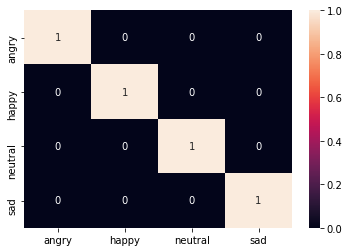

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

In [ ]:
# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_4_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_4_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
p4.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 0.2579 - acc: 0.9237
Epoch 1: val_loss improved from inf to 0.23782, saving model to TESS//models/paper_4_loss_2.h5
140/140 [==============================] - 17s 50ms/step - loss: 0.2579 - acc: 0.9237 - val_loss: 0.2378 - val_acc: 0.9665
Epoch 2/30
139/140 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 1.0000
Epoch 2: val_loss improved from 0.23782 to 0.03450, saving model to TESS//models/paper_4_loss_2.h5
140/140 [==============================] - 5s 37ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9916
Epoch 3/30
139/140 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 1.0000
Epoch 3: val_loss improved from 0.03450 to 0.00586, saving model to TESS//models/paper_4_loss_2.h5
140/140 [==============================] - 5s 36ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 4/30
140/140 [==============================] - ETA: 0s - los

In [ ]:
p4.evaluate(X_test,Y_test)

8/8 [==============================] - 0s 28ms/step - loss: 2.4576e-05 - acc: 1.0000


[2.457626032992266e-05, 1.0]

#Paper_5


In [ ]:
def findmaxsize(rslt_df):
    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']
      y, sr = librosa.core.load(filename,sr = 16000)
      
      #print(y.shape)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('TESS/TESS_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]

max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (64, 299)


In [ ]:
max_x,max_y =(64, 299)
T = 64
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

299 64 320 5


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_mel_spectrogram(df,max_x = max_x,max_y = max_y):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path'] 
      y, sr = librosa.core.load(filename,sr = 16000)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      spect = librosa.power_to_db(spect, ref=np.max)
 
      if spect.shape[1] != max_y:
              spect.resize(max_x,max_y, refcheck=False)

      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        #print(q.shape)
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "TESS//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "TESS//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "TESS//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(1114, 7, 64, 64, 3) (1114, 4)
(239, 7, 64, 64, 3) (239, 4)
(239, 7, 64, 64, 3) (239, 4)


In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((7,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()

(None, 7, 4096)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 64, 64, 3)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 64, 64, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                             

## Trial 1

In [ ]:
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_5_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_5_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p5.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - 55s 141ms/step - loss: 4.8568 - accuracy: 0.5018 - val_loss: 1.2683 - val_accuracy: 0.5690

Epoch 00001: val_loss improved from inf to 1.26830, saving model to TESS//models/paper_5_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.56904, saving model to TESS//models/paper_5_acc.h5
Epoch 2/30
140/140 [==============================] - 19s 134ms/step - loss: 0.8033 - accuracy: 0.6921 - val_loss: 1.5148 - val_accuracy: 0.5607

Epoch 00002: val_loss did not improve from 1.26830

Epoch 00002: val_accuracy did not improve from 0.56904
Epoch 3/30
140/140 [==============================] - 19s 134ms/step - loss: 0.7112 - accuracy: 0.7481 - val_loss: 0.5899 - val_accuracy: 0.7992

Epoch 00003: val_loss improved from 1.26830 to 0.58992, saving model to TESS//models/paper_5_loss.h5

Epoch 00003: val_accuracy improved from 0.56904 to 0.79916, saving model to TESS//models/paper_5_acc.h5
Epoch 4/30
140/140 [==============================

In [ ]:
p5.load_weights('TESS//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('TESS//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 2s 145ms/step - loss: 0.1123 - accuracy: 0.9791
[0.11229915171861649, 0.9790794849395752]
8/8 [==============================] - 1s 92ms/step - loss: 0.1123 - accuracy: 0.9791


[0.11229915171861649, 0.9790794849395752]

F1 SCORE: 0.9787276631909804
Kappa: 0.9720670391061452
Accuracy: 0.9790794979079498
Jaccard Score: 0.9583988052681338
Precision: 0.9793822440999861
Recall: 0.978267240682351
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        62
           1       0.98      0.96      0.97        56
           2       0.98      0.96      0.97        57
           3       0.97      1.00      0.98        64

    accuracy                           0.98       239
   macro avg       0.98      0.98      0.98       239
weighted avg       0.98      0.98      0.98       239



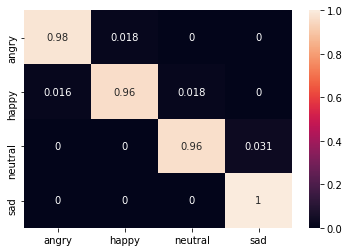

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

In [ ]:
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_5_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_5_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p5.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 2.1071 - accuracy: 0.5718
Epoch 1: val_loss improved from inf to 0.82401, saving model to TESS//models/paper_5_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.66527, saving model to TESS//models/paper_5_acc_2.h5
140/140 [==============================] - 40s 191ms/step - loss: 2.1071 - accuracy: 0.5718 - val_loss: 0.8240 - val_accuracy: 0.6653
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.6768
Epoch 2: val_loss improved from 0.82401 to 0.77638, saving model to TESS//models/paper_5_loss_2.h5

Epoch 2: val_accuracy improved from 0.66527 to 0.72385, saving model to TESS//models/paper_5_acc_2.h5
140/140 [==============================] - 29s 208ms/step - loss: 0.9240 - accuracy: 0.6768 - val_loss: 0.7764 - val_accuracy: 0.7238
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.6514 - accuracy: 0.7639
Epoch 3: val_loss improved from 0.77638 to 0.60

In [ ]:
p5.load_weights('TESS//models//paper_5_acc_2.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('TESS//models//paper_5_loss_2.h5')
p5.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 1s 94ms/step - loss: 0.1792 - accuracy: 0.9623
[0.17915083467960358, 0.9623430967330933]
8/8 [==============================] - 1s 91ms/step - loss: 0.2109 - accuracy: 0.9582


[0.21094420552253723, 0.9581589698791504]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9578580486321738
Kappa: 0.9441458284645945
Accuracy: 0.9581589958158996
Jaccard Score: 0.9193410122669757
Precision: 0.9590839905182988
Recall: 0.9577288735952785
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        62
           1       0.93      0.98      0.96        56
           2       0.98      0.91      0.95        57
           3       0.94      0.97      0.95        64

    accuracy                           0.96       239
   macro avg       0.96      0.96      0.96       239
weighted avg       0.96      0.96      0.96       239



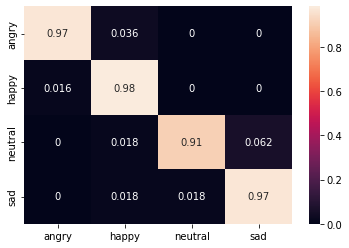

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.9618742310321258
Kappa: 0.949688917995977
Accuracy: 0.9623430962343096
Jaccard Score: 0.9267593793563745
Precision: 0.9646009392728015
Recall: 0.9606450602312232
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        62
           1       0.98      0.95      0.96        56
           2       0.98      0.91      0.95        57
           3       0.93      1.00      0.96        64

    accuracy                           0.96       239
   macro avg       0.96      0.96      0.96       239
weighted avg       0.96      0.96      0.96       239



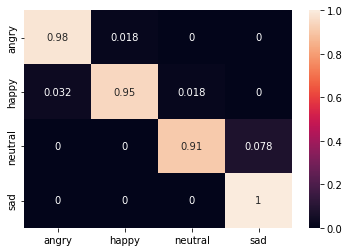

In [ ]:
#test set
p5.load_weights('TESS//models//paper_5_acc_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Paper 6

In [ ]:
max_x = 96
max_y = 299
T = 64
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

299 64 320 5


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = max_x)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "TESS//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "TESS//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "TESS//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(1114, 5, 96, 64, 3) (1114, 4)
(239, 5, 96, 64, 3) (239, 4)
(239, 5, 96, 64, 3) (239, 4)


In [ ]:
import keras

def VGG_net():
  input = Input((96,64,3))
  t = Conv2D(64, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(input)
  t = Conv2D(64, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(128, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(128, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Flatten()(t)

  t = Dense(4096, activation = 'relu')(t)
  t = Dense(4096, activation = 'relu')(t)
  t = Dense(128, activation = 'relu')(t)

  t = Reshape((1,128))(t)

  return Model(inputs = input, outputs = t)


#change shape
def paper_6():
  ip = Input((5, 96,64,3))
  vgg = VGG_net()

  for i in range(ip.shape[1]):
    op_layer = vgg(ip[:,i,:,:,:])
    if i==0:
      op_layers = op_layer
    else:
      op_layers = Concatenate(axis = 1)([op_layers,op_layer])

  lstmb = Bidirectional(LSTM(256,return_sequences=True), merge_mode = 'sum')
  t = lstmb(op_layers)  
  lstmb2 = Bidirectional(LSTM(256,return_sequences=True), merge_mode = None)
  t2 = lstmb2(t)  

  h1 = t2[0]
  h2 = t2[1]
  print(h1.shape, h2.shape)
  h1 = Softmax(axis = -1)(h1)
  h2 = Softmax(axis =-1)(h2)
  

  sum1 = tf.keras.backend.sum(axis =1,x = h1)
  sum2 = tf.keras.backend.sum(axis =1,x= h2)
  sum = Concatenate()([sum1,sum2])
  print(sum.shape)

  mean1 = sum1/256.
  mean2 = sum2/256.
  mean = Concatenate()([mean1, mean2])

  std1 = tf.keras.backend.std(axis =1, x= h1)
  std2 =tf.keras.backend.std(axis =1, x =h2)
  std = Concatenate()([std1, std2])

  min1 = tf.keras.backend.min(axis =1,x=h1)
  min2 = tf.keras.backend.min(axis =1, x=h2)
  min = Concatenate()([min1, min2])

  max1 = tf.keras.backend.max(axis =1, x=h1)
  max2 = tf.keras.backend.max(axis=1, x =h2)
  max = Concatenate()([max1,max2])

  attention = Concatenate()([sum, mean, std, min, max])
  print(attention.shape)

  fc1 = Dense(512, activation = 'relu')(attention)
  fc2 = Dense(4, activation = 'softmax')(fc1)  


  return Model(inputs=ip,outputs=fc2)

p6 = paper_6()
p6.summary()

(None, 5, 256) (None, 5, 256)
(None, 512)
(None, 2560)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5, 96, 64, 3 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 96, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 96, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1, 128)       49917120    tf.__operators__.getitem_5[0][0] 
                                     

In [ ]:
p6.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//paper_6_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//paper_6_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p6.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
140/140 [==============================] - 37s 217ms/step - loss: 1.3935 - accuracy: 0.2234 - val_loss: 1.3940 - val_accuracy: 0.2050

Epoch 00001: val_loss improved from inf to 1.39399, saving model to TESS//models/paper_6_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.20502, saving model to TESS//models/paper_6_acc.h5
Epoch 2/30
140/140 [==============================] - 29s 208ms/step - loss: 1.3861 - accuracy: 0.2624 - val_loss: 1.3907 - val_accuracy: 0.2385

Epoch 00002: val_loss improved from 1.39399 to 1.39074, saving model to TESS//models/paper_6_loss.h5

Epoch 00002: val_accuracy improved from 0.20502 to 0.23849, saving model to TESS//models/paper_6_acc.h5
Epoch 3/30
140/140 [==============================] - 29s 210ms/step - loss: 1.3872 - accuracy: 0.2550 - val_loss: 1.3963 - val_accuracy: 0.2050

Epoch 00003: val_loss did not improve from 1.39074

Epoch 00003: val_accuracy did not improve from 0.23849
Epoch 4/30
140/140 [==============================

In [ ]:
p6.load_weights('TESS//models//paper_6_acc.h5')
print(p6.evaluate(X_test_spec,Y_test_spec))
p6.load_weights('TESS//models//paper_6_loss.h5')
p6.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 1s 112ms/step - loss: 1.0972 - accuracy: 0.4812
[1.0971777439117432, 0.48117154836654663]
8/8 [==============================] - 1s 113ms/step - loss: 1.0748 - accuracy: 0.4686


[1.0748317241668701, 0.4686192572116852]

# Jan 2022

## Ensembled

In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

### Testing on Emo-db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
csvpath = 'EMO_DB/hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 26) (237, 1)
(50, 26) (50, 1)
(51, 26) (51, 1)


In [ ]:
ensembled.load_weights("TESS//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("TESS//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 10s 395ms/step - loss: 3.5288 - accuracy: 0.5600
[3.528780937194824, 0.5600000023841858]
2/2 [==============================] - 0s 97ms/step - loss: 1.5731 - accuracy: 0.5800


[1.5730894804000854, 0.5799999833106995]

2/2 [==============================] - 0s 117ms/step - loss: 1.5731 - accuracy: 0.5800
[1.5730894804000854, 0.5799999833106995]
F1 SCORE: 0.5308357893497212
Kappa: 0.4274809160305344
Accuracy: 0.58
Jaccard Score: 0.37767516617631036
Precision: 0.5444444444444445
Recall: 0.548051948051948


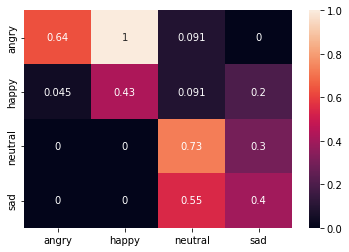

In [ ]:

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

### Testing on Crema D

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 64000, 1) (3430, 4)
Test Data (735, 64000, 1) (735, 4)
Val Data (735, 64000, 1) (735, 4)


In [ ]:
csvpath = 'CREMA/hand_engineered_features_CREMA_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(3430, 26) (3430, 1)
(735, 26) (735, 1)
(735, 26) (735, 1)


In [ ]:
ensembled.load_weights("TESS//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("TESS//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

23/23 [==============================] - 4s 161ms/step - loss: 4.0225 - accuracy: 0.4286
[4.022480487823486, 0.4285714328289032]
23/23 [==============================] - 4s 160ms/step - loss: 1.8934 - accuracy: 0.4422


[1.8933709859848022, 0.442176878452301]

23/23 [==============================] - 4s 162ms/step - loss: 1.8934 - accuracy: 0.4422
[1.8933709859848022, 0.442176878452301]
F1 SCORE: 0.43905951405951404
Kappa: 0.2589997049277072
Accuracy: 0.4421768707482993
Jaccard Score: 0.28660721336256867
Precision: 0.4403792299483251
Recall: 0.4497897559226839


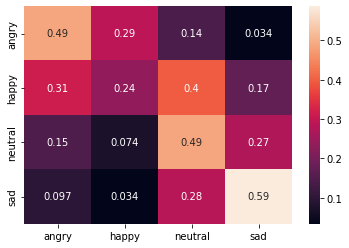

In [ ]:

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

### Testing on Savee (manipulated)

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
csvpath = 'SAVEE/hand_engineered_features_SAVEE_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(207, 26) (207, 1)
(45, 26) (45, 1)
(44, 26) (44, 1)


In [ ]:
ensembled.load_weights("TESS//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("TESS//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 377ms/step - loss: 2.5565 - accuracy: 0.6000
[2.5565497875213623, 0.6000000238418579]
2/2 [==============================] - 0s 85ms/step - loss: 1.2164 - accuracy: 0.6889


[1.216365098953247, 0.6888889074325562]

2/2 [==============================] - 0s 108ms/step - loss: 1.2164 - accuracy: 0.6889
[1.216365098953247, 0.6888889074325562]
F1 SCORE: 0.6375816993464052
Kappa: 0.5625
Accuracy: 0.6888888888888889
Jaccard Score: 0.4829545454545454
Precision: 0.7077497665732959
Recall: 0.6408730158730158


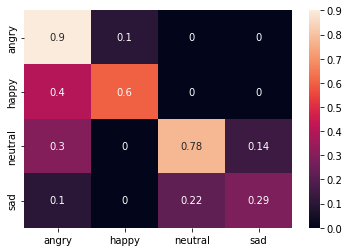

In [ ]:

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Wavenet

In [ ]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(4)] * 2 
sr = 16000
time = 4
# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(int(sr*time), 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))
out = AveragePooling1D(sr*time)(out)
out = Conv1D(8,1,activation='relu')(out)
out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet_paper = Model(history_seq, out)
Wavenet_paper.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 16)    32          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 32)    1056        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 64000, 32)    1056        ['conv1d[0][0]']                 
                                                                                              

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


### Testing on emo db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
csvpath = 'EMO_DB/hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 26) (237, 1)
(50, 26) (50, 1)
(51, 26) (51, 1)


In [ ]:
Wavenet_paper.load_weights('TESS//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('TESS//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

2/2 [==============================] - 12s 888ms/step - loss: 6.9970 - accuracy: 0.5900
[6.9969587326049805, 0.5899999737739563]
2/2 [==============================] - 2s 572ms/step - loss: 6.9970 - accuracy: 0.5900


[6.9969587326049805, 0.5899999737739563]

2/2 [==============================] - 1s 565ms/step - loss: 6.9970 - accuracy: 0.5900
(50,) (50,)
F1 SCORE: 0.11429608127721334
Kappa: 0.019138755980861344
Accuracy: 0.18
Jaccard Score: 0.06452358926919519
Precision: 0.22010869565217392
Recall: 0.24837662337662336
              precision    recall  f1-score   support

           0       0.75      0.14      0.23        22
           1       0.13      0.86      0.23         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.18        50
   macro avg       0.22      0.25      0.11        50
weighted avg       0.35      0.18      0.13        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

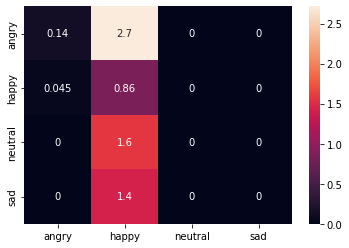

In [ ]:
Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))
cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

### Testing on Crema D

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 64000, 1) (3430, 4)
Test Data (735, 64000, 1) (735, 4)
Val Data (735, 64000, 1) (735, 4)


In [ ]:
csvpath = 'CREMA/hand_engineered_features_CREMA_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(3430, 26) (3430, 1)
(735, 26) (735, 1)
(735, 26) (735, 1)


In [ ]:
Wavenet_paper.load_weights('TESS//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('TESS//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

23/23 [==============================] - 21s 917ms/step - loss: 1.3119 - accuracy: 0.7129
[1.311897873878479, 0.7129251956939697]
23/23 [==============================] - 21s 891ms/step - loss: 1.3119 - accuracy: 0.7129


[1.311897873878479, 0.7129251956939697]

23/23 [==============================] - 21s 889ms/step - loss: 1.3119 - accuracy: 0.7129
(735,) (735,)
F1 SCORE: 0.4035121315843354
Kappa: 0.23986685663751606
Accuracy: 0.4272108843537415
Jaccard Score: 0.26954535030516813
Precision: 0.39791484120991927
Recall: 0.4376252564255768
              precision    recall  f1-score   support

           0       0.35      0.47      0.40       176
           1       0.23      0.12      0.16       204
           2       0.44      0.34      0.38       176
           3       0.56      0.83      0.67       179

    accuracy                           0.43       735
   macro avg       0.40      0.44      0.40       735
weighted avg       0.39      0.43      0.40       735



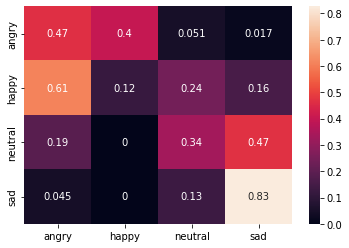

In [ ]:
Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))
cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

### Testing on Savee

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
csvpath = 'SAVEE/hand_engineered_features_SAVEE_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(207, 26) (207, 1)
(45, 26) (45, 1)
(44, 26) (44, 1)


In [ ]:
Wavenet_paper.load_weights('TESS//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('TESS//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

2/2 [==============================] - 2s 717ms/step - loss: 7.3435 - accuracy: 0.6389
[7.3435282707214355, 0.6388888955116272]
2/2 [==============================] - 1s 437ms/step - loss: 7.3435 - accuracy: 0.6389


[7.3435282707214355, 0.6388888955116272]

2/2 [==============================] - 1s 449ms/step - loss: 7.3435 - accuracy: 0.6389
(45,) (45,)
F1 SCORE: 0.16173361522198731
Kappa: 0.03591682419659736
Accuracy: 0.24444444444444444
Jaccard Score: 0.10075757575757577
Precision: 0.13825757575757575
Recall: 0.2857142857142857
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.30      1.00      0.47        10
           2       0.00      0.00      0.00        18
           3       0.25      0.14      0.18         7

    accuracy                           0.24        45
   macro avg       0.14      0.29      0.16        45
weighted avg       0.11      0.24      0.13        45



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

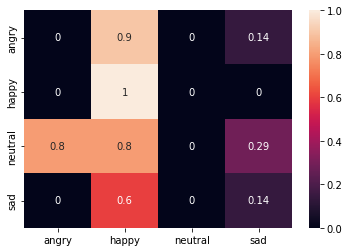

In [ ]:
Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))
cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## Paper 1

In [ ]:
def paper_model():
  inp = Input((352800,1))
  l1 = BatchNormalization()(Conv1D(32,21,activation='relu',padding = 'same')(inp))
  m1 = MaxPool1D(2)(l1)

  l2 = BatchNormalization()(Conv1D(64,19,activation='relu',padding = 'same')(m1))
  m2 = MaxPool1D(2)(l2)

  l3 = BatchNormalization()(Conv1D(128,17,activation='relu',padding = 'same')(m2))
  m3 = MaxPool1D(2)(l3)


  l4 = BatchNormalization()(Conv1D(256,15,activation='relu',padding = 'same')(m3))
  m4 = MaxPool1D(2)(l4)

  l5 = BatchNormalization()(Conv1D(512,13,activation='relu',padding = 'same')(m4))
  m5 = MaxPool1D(2)(l5)

  l6 = BatchNormalization()(Conv1D(1024,11,activation='relu',padding = 'same')(m5))
  m6 = MaxPool1D(2)(l6)

  l7 = BatchNormalization()(Conv1D(1024,9,activation='relu',padding = 'same')(m6))
  m7 = GlobalMaxPool1D()(l7)

  fl = Flatten()(m7)
  d1 = Dense(128,activation='relu')(fl)
  out = Dense(4,activation='softmax')(d1)

  return Model(inputs = inp,outputs = out)

m = paper_model()
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 352800, 1)]       0         
                                                                 
 conv1d (Conv1D)             (None, 352800, 32)        704       
                                                                 
 batch_normalization (BatchN  (None, 352800, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 176400, 32)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 176400, 64)        38976     
                                                                 
 batch_normalization_1 (Batc  (None, 176400, 64)       256   

In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### Testing on emo db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 8
srk = 44100
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 352800, 1) (237, 4)
Test Data (50, 352800, 1) (50, 4)
Val Data (51, 352800, 1) (51, 4)


In [ ]:
m.load_weights('TESS//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('TESS//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

2/2 [==============================] - 57s 17s/step - loss: 5.2522 - accuracy: 0.5000
[5.252240180969238, 0.5]
2/2 [==============================] - 9s 3s/step - loss: 5.2522 - accuracy: 0.5000


[5.252240180969238, 0.5]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.3557279111204277
Kappa: 0.266001174398121
Accuracy: 0.5
Jaccard Score: 0.24855072463768113
Precision: 0.32476190476190475
Recall: 0.400974025974026
              precision    recall  f1-score   support

           0       0.68      0.77      0.72        22
           1       0.29      0.29      0.29         7
           2       0.33      0.55      0.41        11
           3       0.00      0.00      0.00        10

    accuracy                           0.50        50
   macro avg       0.32      0.40      0.36        50
weighted avg       0.41      0.50      0.45        50



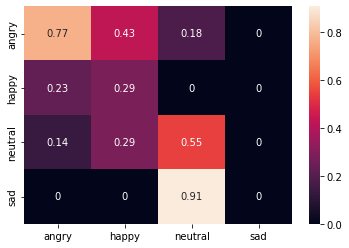

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on Crema D

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 8
srk = 44100
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]
  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  for index, row in rslt_df.iterrows(): 
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)
  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 352800, 1) (3430, 4)
Test Data (735, 352800, 1) (735, 4)
Val Data (735, 352800, 1) (735, 4)


In [ ]:
m.load_weights('TESS//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('TESS//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

23/23 [==============================] - 184s 6s/step - loss: 3.7487 - accuracy: 0.4381
[3.748687982559204, 0.43809524178504944]
23/23 [==============================] - 119s 5s/step - loss: 3.7487 - accuracy: 0.4381


[3.748687982559204, 0.43809524178504944]

F1 SCORE: 0.41706556974951264
Kappa: 0.25798408682579843
Accuracy: 0.4380952380952381
Jaccard Score: 0.27489420512035523
Precision: 0.459530120713349
Recall: 0.4513444915802786
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       176
           1       0.44      0.10      0.16       204
           2       0.33      0.61      0.43       176
           3       0.53      0.50      0.52       179

    accuracy                           0.44       735
   macro avg       0.46      0.45      0.42       735
weighted avg       0.46      0.44      0.41       735



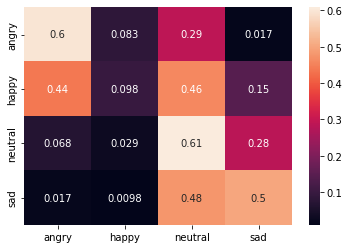

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 8
srk = 44100
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 352800, 1) (207, 4)
Test Data (45, 352800, 1) (45, 4)
Val Data (44, 352800, 1) (44, 4)


In [ ]:
m.load_weights('TESS//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('TESS//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

2/2 [==============================] - 22s 17s/step - loss: 2.4457 - accuracy: 0.6000
[2.445659637451172, 0.6000000238418579]
2/2 [==============================] - 8s 3s/step - loss: 2.4457 - accuracy: 0.6000


[2.445659637451172, 0.6000000238418579]

F1 SCORE: 0.48542510121457483
Kappa: 0.44060773480662985
Accuracy: 0.6
Jaccard Score: 0.3670634920634921
Precision: 0.46977124183006536
Recall: 0.5194444444444445
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.50      0.80      0.62        10
           2       0.82      0.78      0.80        18
           3       0.00      0.00      0.00         7

    accuracy                           0.60        45
   macro avg       0.47      0.52      0.49        45
weighted avg       0.56      0.60      0.57        45



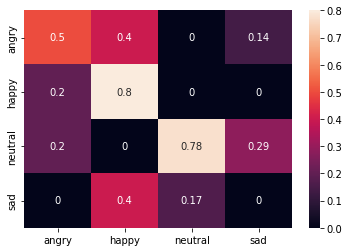

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 2

In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('TESS/TESS_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]

max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (64, 299)


In [ ]:
T=80
max_x = 64
max_y = 299
import keras
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Reshape((36,256))(X)

    X= LSTM(256,return_sequences=True)(X)
    X= LSTM(256)(X)

    
    #X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    #X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    

    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    return model

def paper_2():
    input_layer = Input((int(max_y/T)+1,max_x,T,3))
    alex = AlexNet((227,227,3))
    
    for i in range(int(max_y/T)+1):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      
      cnn = alex(inp)

      #cnn = Reshape((1,4096))(cnn)

      if i == 0:
        output_layers = cnn
      else:
        output_layers = Concatenate(axis = 1)([output_layers,cnn])
      
    
    #print(len(output_layers))
    #lstm = LSTM(256,return_sequences=True)(output_layers)
    #lstm = LSTM(256,return_sequences=True)(lstm)
    #lstm = LSTM(256)(lstm)
    
    out = Dense(4,activation='softmax')(output_layers)
    
    
    
    return Model(inputs=input_layer,outputs=out)
p2 = paper_2()
p2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 64, 80,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 64, 80, 3)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 64, 80, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### Testing  on Emo db

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(237, 4, 64, 80, 3) (237, 4)
(50, 4, 64, 80, 3) (50, 4)
(51, 4, 64, 80, 3) (51, 4)


In [ ]:
p2.load_weights('TESS//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('TESS//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 15s 755ms/step - loss: 3.3971 - accuracy: 0.3000
[3.3970611095428467, 0.30000001192092896]
2/2 [==============================] - 0s 178ms/step - loss: 3.0904 - accuracy: 0.4000


[3.0904080867767334, 0.4000000059604645]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.2151359504300681
Kappa: 0.02343749999999989
Accuracy: 0.3
Jaccard Score: 0.1327468487394958
Precision: 0.23035714285714287
Recall: 0.2409090909090909
              precision    recall  f1-score   support

           0       0.60      0.41      0.49        22
           1       0.00      0.00      0.00         7
           2       0.18      0.45      0.26        11
           3       0.14      0.10      0.12        10

    accuracy                           0.30        50
   macro avg       0.23      0.24      0.22        50
weighted avg       0.33      0.30      0.29        50



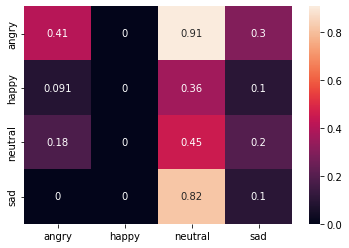

In [ ]:
#test set
p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on  Crema D

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "CREMA//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "CREMA//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "CREMA//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(3430, 4, 64, 80, 3) (3430, 4)
(735, 4, 64, 80, 3) (735, 4)
(735, 4, 64, 80, 3) (735, 4)


In [ ]:
p2.load_weights('TESS//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('TESS//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

23/23 [==============================] - 19s 161ms/step - loss: 4.6277 - accuracy: 0.2735
[4.627744197845459, 0.27346938848495483]
23/23 [==============================] - 4s 153ms/step - loss: 4.7039 - accuracy: 0.2830


[4.703924655914307, 0.2829931974411011]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.19961506418693392
Kappa: 0.042772688694430516
Accuracy: 0.27346938775510204
Jaccard Score: 0.12209327315710294
Precision: 0.21715168787283695
Recall: 0.28317832656170644
              precision    recall  f1-score   support

           0       0.29      0.03      0.05       176
           1       0.00      0.00      0.00       204
           2       0.22      0.56      0.32       176
           3       0.35      0.55      0.43       179

    accuracy                           0.27       735
   macro avg       0.22      0.28      0.20       735
weighted avg       0.21      0.27      0.19       735



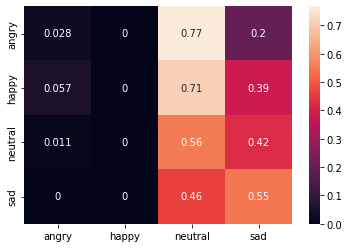

In [ ]:
#test set
p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 4, 64, 80, 3) (207, 4)
(45, 4, 64, 80, 3) (45, 4)
(44, 4, 64, 80, 3) (44, 4)


In [ ]:
p2.load_weights('TESS//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('TESS//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 1s 775ms/step - loss: 4.0863 - accuracy: 0.4000
[4.086273670196533, 0.4000000059604645]
2/2 [==============================] - 0s 97ms/step - loss: 3.5226 - accuracy: 0.4000


[3.5226175785064697, 0.4000000059604645]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.14285714285714288
Kappa: 0.0
Accuracy: 0.4
Jaccard Score: 0.1
Precision: 0.1
Recall: 0.25
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.40      1.00      0.57        18
           3       0.00      0.00      0.00         7

    accuracy                           0.40        45
   macro avg       0.10      0.25      0.14        45
weighted avg       0.16      0.40      0.23        45



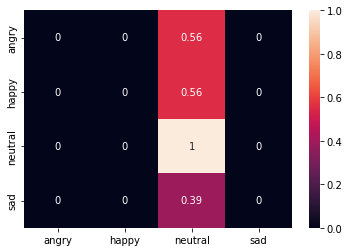

In [ ]:
#test set
p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 3

In [ ]:
time = 4
def paper_3():
  inp =  Input((time*16000,1))
  l1 = Conv1D(64,80,strides = 4,padding = 'same')(inp)
  m1 = MaxPooling1D(4)(l1)

  l2 = Conv1D(128,3,strides = 1,padding = 'same')(m1)
  l2 = Conv1D(128,3,strides = 1,padding = 'same')(l2)
  m2 = MaxPooling1D(4)(l2)

  l3 = Conv1D(256,3,strides = 1,padding = 'same')(m2)
  l3 = Conv1D(256,3,strides = 1,padding = 'same')(l3)
  m3 = MaxPooling1D(4)(l3)

  l4 = Conv1D(512,3,strides = 1,padding = 'same')(m3)
  l4 = Conv1D(512,3,strides = 1,padding = 'same')(l4)
  m4 = GlobalAveragePooling1D()(l4)

  f1 = Dense(1024)(m4)
  f2 = Dense(4, activation='softmax')(f1)

  return Model(inputs= inp,outputs=f2)

p3 = paper_3()
p3.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 16000, 64)         5184      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4000, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4000, 128)         24704     
                                                                 
 conv1d_2 (Conv1D)           (None, 4000, 128)         49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1000, 128)        0         
 1D)                                                       

In [ ]:
p3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### Testing on Emo db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
p3.save_weights('TESS//models//paper_3_acc.h5')
#p3.load_weights('TESS//models//paper_3_acc.h5')
#print(p3.evaluate(X_test,Y_test))
#p3.load_weights('TESS//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

2/2 [==============================] - 2s 330ms/step - loss: 1.3900 - accuracy: 0.2200


[1.3899999856948853, 0.2199999988079071]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.09016393442622951
Kappa: 0.0
Accuracy: 0.22
Jaccard Score: 0.055
Precision: 0.055
Recall: 0.25
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00         7
           2       0.22      1.00      0.36        11
           3       0.00      0.00      0.00        10

    accuracy                           0.22        50
   macro avg       0.06      0.25      0.09        50
weighted avg       0.05      0.22      0.08        50



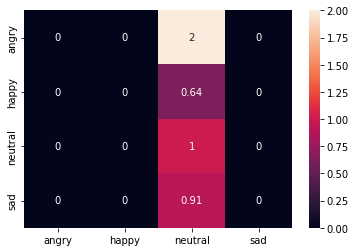

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on Crema D

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 64000, 1) (3430, 4)
Test Data (735, 64000, 1) (735, 4)
Val Data (735, 64000, 1) (735, 4)


In [ ]:
p3.save_weights('TESS//models//paper_3_acc.h5')
#p3.load_weights('TESS//models//paper_3_acc.h5')
#print(p3.evaluate(X_test,Y_test))
#p3.load_weights('TESS//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

23/23 [==============================] - 2s 100ms/step - loss: 1.3880 - accuracy: 0.2395


[1.3879621028900146, 0.23945578932762146]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.09659714599341383
Kappa: 0.0
Accuracy: 0.23945578231292516
Jaccard Score: 0.05986394557823129
Precision: 0.05986394557823129
Recall: 0.25
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.00      0.00      0.00       204
           2       0.24      1.00      0.39       176
           3       0.00      0.00      0.00       179

    accuracy                           0.24       735
   macro avg       0.06      0.25      0.10       735
weighted avg       0.06      0.24      0.09       735



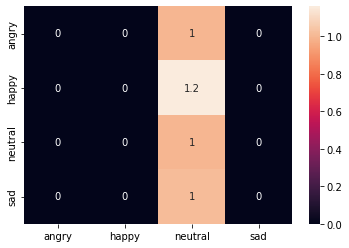

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
p3.save_weights('TESS//models//paper_3_acc.h5')
#p3.load_weights('TESS//models//paper_3_acc.h5')
#print(p3.evaluate(X_test,Y_test))
#p3.load_weights('TESS//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 311ms/step - loss: 1.3893 - accuracy: 0.4000


[1.3893481492996216, 0.4000000059604645]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.14285714285714288
Kappa: 0.0
Accuracy: 0.4
Jaccard Score: 0.1
Precision: 0.1
Recall: 0.25
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.40      1.00      0.57        18
           3       0.00      0.00      0.00         7

    accuracy                           0.40        45
   macro avg       0.10      0.25      0.14        45
weighted avg       0.16      0.40      0.23        45



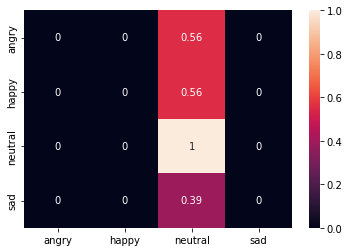

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 4

In [ ]:
! pip install Signal_Analysis kapre
import numpy as np
import pandas as pd

import ast
import os
from tqdm.notebook import tqdm
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sound Processing
import librosa
from Signal_Analysis.features.signal import get_F_0, get_HNR

# Training Data Preparation
from sklearn.model_selection import train_test_split



import tensorflow as tf
#from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
import numpy as np
import librosa.display
import IPython.display as ipd

     |████████████████████████████████| 378 kB 4.5 MB/s 
  Created wheel for Signal-Analysis: filename=Signal_Analysis-0.1.26-py3-none-any.whl size=14531 sha256=67e84a67a5df5da7779a1648bf9a0bbcf26d38e1d5b2e564483b3240723ad72b
  Stored in directory: /root/.cache/pip/wheels/72/da/25/128af0db67fe61f8282e790d94387346357c063d72522661d6
Successfully built Signal-Analysis


In [ ]:
NUM_EMOTIONS = 4
N_FFT = 4096
HOP_LENGTH = 1024
EMOTIONS = ['ang', 'hap', 'neu', 'sad']
SR = 16000


def extract_HSF(lld):
    mean_val = lld.mean()
    min_val = lld.min()
    max_val = lld.max()
    var_val = lld.var()
    range_val = np.subtract(max_val, min_val)
    q25_val = np.quantile(lld, 0.25)
    q50_val = np.quantile(lld, 0.5)
    q75_val = np.quantile(lld, 0.75)
    return np.asarray([
        mean_val,
        min_val,
        max_val,
        var_val,
        range_val,
        q25_val,
        q50_val,
        q75_val,
    ])

def extract_LLD_from_subaudio(subaudio, fs):
    # Frame-wise energy
    energy_val = np.sum(np.square(subaudio)) / (subaudio.shape[0] / fs + 0.00000000000001)
    
    # Frame-wise Zero Crossing Rate
    zcr_val = np.sum((subaudio[:-1] * subaudio[1:]) < 0)
    
    return np.asarray([
        energy_val,
        zcr_val,
    ])

def extract_LLD_from_audio(audio, fs):
    # MFCC
    mfcc = librosa.feature.mfcc(audio, fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False).transpose()
    mfcc_hsf = extract_HSF(mfcc)
    
    # LPC
    lpc = librosa.lpc(audio, 16)
    
    # Mel-Spectrogram
    spect = librosa.feature.melspectrogram(y = audio, sr = fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False)
    spect = librosa.power_to_db(spect, ref = np.max).transpose()
    spect_hsf = extract_HSF(spect)
    
    # Other features
    f0 = get_F_0(audio, fs)[0]
    hnr = get_HNR(audio, fs)
    
    return np.asarray(mfcc), np.asarray(mfcc_hsf), np.asarray(lpc), np.asarray(spect), np.asarray(spect_hsf), np.asarray([f0, hnr])

def extract_LLD(audio, fs):
    #print(audio.shape)
    #print(int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1)
    num_windows = int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1
    framewise_lld = np.zeros((num_windows, 2))
    for idx in range(num_windows):
        subaudio = audio[int(idx * HOP_LENGTH): int(idx * HOP_LENGTH + N_FFT)]
        framewise_lld[idx, :] = extract_LLD_from_subaudio(subaudio, fs)
    framewise_lld_hsf = extract_HSF(framewise_lld)
    
    mfcc, mfcc_hsf, lpc, spect, spect_hsf, others = extract_LLD_from_audio(audio, fs)
    
    assert(framewise_lld.shape[0] == mfcc.shape[0])
    assert(mfcc.shape[0] == spect.shape[0])

    rnn_feats = np.concatenate((framewise_lld, mfcc, spect), axis = 1)
    dense_feats = np.concatenate((framewise_lld_hsf, mfcc_hsf, lpc, spect_hsf, others))
    return rnn_feats, dense_feats

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,4*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:

def RNNSpeechModel(no_of_classes, input_size):
  
  # x = tf.keras.layers.Input((input_len,))
  # x = tf.keras.layers.Reshape((1,-1))(x)
  # m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
  #                      padding='same', sr=sr, n_mels=80,
  #                      fmin=40.0, fmax=sr / 2, power_melgram=1.0,
  #                      return_decibel_melgram=True, trainable_fb=False,
  #                      trainable_kernel=False,
  #                      name='mel_stft')
  # m.trainable = False
  # x = m(x)
  #x = Normalization2D(int_axis=0)(x)
  #x = tf.keras.layers.Permute((2,1,3))(x)

  input = tf.keras.layers.Input((input_size))
  #Bidirectional RNN
  x = tf.keras.layers.Conv2D(10,(5,1),activation='relu',padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(1,(5,1),activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)
  #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)

  #Attention unit
  xFirst = tf.keras.layers.Lambda(lambda q: q[:,-1])(x)
  query = tf.keras.layers.Dense(128)(xFirst)
  att_score = tf.keras.layers.Dot(axes=[1,2])([query,x])
  att_score = tf.keras.layers.Softmax()(att_score)

  #weighted pooling
  att_vector = tf.keras.layers.Dot(axes=[1,1])([att_score,x])
  #x = tf.keras.layers.Dense(64,activation='relu')(att_vector)
  #x = tf.keras.layers.Dense(32,activation='relu')(x)
  output = tf.keras.layers.Dense(no_of_classes,activation='softmax')(att_vector)

  model = tf.keras.models.Model(inputs = input,outputs = output)
  return model
  
no_of_classes = 4
input_size = X_train[0].shape
p4 = RNNSpeechModel(no_of_classes,input_size)
p4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
p4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 59, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 59, 150, 10)  60          ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 59, 150, 10)  40         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

### Testing on Emo db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,4*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:
p4.load_weights('TESS//models//paper_4_loss.h5')
p4.evaluate(X_test,Y_test)

2/2 [==============================] - 2s 66ms/step - loss: 2.8070 - acc: 0.3600


[2.8069710731506348, 0.36000001430511475]

F1 SCORE: 0.2853067765567766
Kappa: 0.08045977011494243
Accuracy: 0.36
Jaccard Score: 0.17709627329192545
Precision: 0.4027777777777778
Recall: 0.2918831168831169
              precision    recall  f1-score   support

           0       0.50      0.59      0.54        22
           1       0.11      0.29      0.16         7
           2       0.50      0.09      0.15        11
           3       0.50      0.20      0.29        10

    accuracy                           0.36        50
   macro avg       0.40      0.29      0.29        50
weighted avg       0.45      0.36      0.35        50



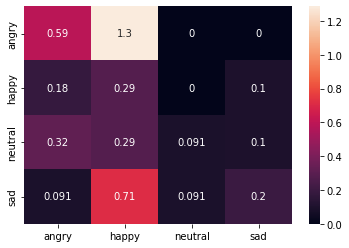

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on CREMA

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,4*SR)
    try :
      rnn_feats, dense_feats = extract_LLD(y, SR)
      X.append(rnn_feats)
      Y.append(label_to_onehot(row['labels']))
    except:
      print("Error",row['path'])
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Streaming output truncated to the last 5000 lines.

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:
p4.load_weights('TESS//models//paper_4_loss.h5')
p4.evaluate(X_test,Y_test)

23/23 [==============================] - 0s 19ms/step - loss: 3.2281 - acc: 0.3143


[3.2281222343444824, 0.3142857253551483]

F1 SCORE: 0.2997925251603066
Kappa: 0.09029738955330169
Accuracy: 0.3142857142857143
Jaccard Score: 0.17817345656917458
Precision: 0.32301245396128636
Recall: 0.31935813939593105
              precision    recall  f1-score   support

           0       0.29      0.36      0.32       176
           1       0.34      0.16      0.22       204
           2       0.35      0.21      0.26       176
           3       0.31      0.55      0.40       179

    accuracy                           0.31       735
   macro avg       0.32      0.32      0.30       735
weighted avg       0.32      0.31      0.30       735



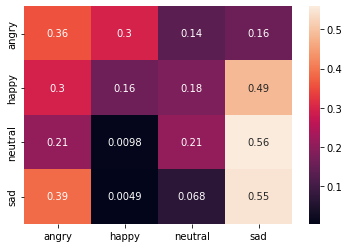

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,4*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:
p4.load_weights('TESS//models//paper_4_loss.h5')
p4.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 61ms/step - loss: 3.6440 - acc: 0.3111


[3.643960952758789, 0.31111112236976624]

F1 SCORE: 0.2806962685011465
Kappa: 0.13246268656716442
Accuracy: 0.3111111111111111
Jaccard Score: 0.1765625
Precision: 0.3680351906158358
Recall: 0.37142857142857144
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.29      0.90      0.44        10
           2       0.00      0.00      0.00        18
           3       0.18      0.29      0.22         7

    accuracy                           0.31        45
   macro avg       0.37      0.37      0.28        45
weighted avg       0.32      0.31      0.23        45



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

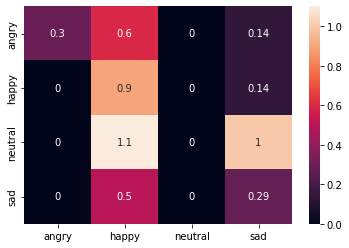

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 5

In [ ]:
max_x,max_y=(64,299)

In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((27,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

(None, 27, 4096)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 27, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 64, 64, 3)   0           ['input_3[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 64, 64, 3)   0           ['input_3[0][0]']                
 icingOpLambda)                                                            

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot

def extract_mel_spectrogram(df,max_x = 64,max_y = 898):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))
        z = np.concatenate((q,delta,d_delta),axis = -1)
        s.append(z)

      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
print(X_val_spec.shape,Y_val_spec.shape)

(237, 27, 64, 64, 3) (237, 4)
(50, 27, 64, 64, 3) (50, 4)
(51, 27, 64, 64, 3) (51, 4)


In [ ]:
p5.load_weights('TESS//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('TESS//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 16s 1s/step - loss: 29.5725 - accuracy: 0.4400
[29.572500228881836, 0.4399999976158142]
2/2 [==============================] - 2s 675ms/step - loss: 29.5725 - accuracy: 0.4400


[29.5725040435791, 0.4399999976158142]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.1527777777777778
Kappa: 0.0
Accuracy: 0.44
Jaccard Score: 0.11
Precision: 0.11
Recall: 0.25
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.44        50
   macro avg       0.11      0.25      0.15        50
weighted avg       0.19      0.44      0.27        50



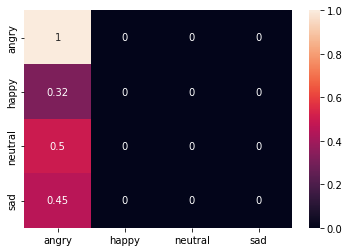

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on CREMA

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_mel_spectrogram(df,max_x = 64,max_y = 501):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path'] 
      y, sr = librosa.core.load(filename,sr = 16000)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      spect = librosa.power_to_db(spect, ref=np.max)
 
      if spect.shape[1] != max_y:
              spect.resize(max_x,max_y, refcheck=False)

      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        #print(q.shape)
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "CREMA//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "CREMA//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "CREMA//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(3430, 14, 64, 64, 3) (3430, 4)
(735, 14, 64, 64, 3) (735, 4)
(735, 14, 64, 64, 3) (735, 4)


In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((14,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

(None, 14, 4096)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 14, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.__operators__.getitem_33 (S  (None, 64, 64, 3)   0           ['input_7[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_34 (S  (None, 64, 64, 3)   0           ['input_7[0][0]']                
 licingOpLambda)                                                           

In [ ]:
p5.load_weights('TESS//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('TESS//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

23/23 [==============================] - 17s 477ms/step - loss: 23.2334 - accuracy: 0.2748
[23.233396530151367, 0.2748299241065979]
23/23 [==============================] - 11s 465ms/step - loss: 23.2334 - accuracy: 0.2748


[23.233396530151367, 0.2748299241065979]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.1619248895562287
Kappa: 0.04194128220491322
Accuracy: 0.2748299319727891
Jaccard Score: 0.09782379891035166
Precision: 0.18458646616541352
Recall: 0.28030303030303033
              precision    recall  f1-score   support

           0       0.25      0.95      0.40       176
           1       0.49      0.17      0.25       204
           2       0.00      0.00      0.00       176
           3       0.00      0.00      0.00       179

    accuracy                           0.27       735
   macro avg       0.18      0.28      0.16       735
weighted avg       0.20      0.27      0.16       735



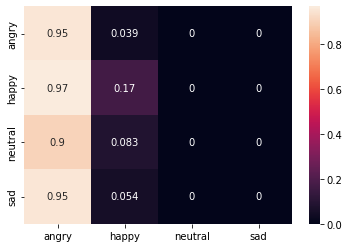

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_mel_spectrogram(df,max_x = 64,max_y = 714):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path'] 
      y, sr = librosa.core.load(filename,sr = 16000)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      spect = librosa.power_to_db(spect, ref=np.max)
 
      if spect.shape[1] != max_y:
              spect.resize(max_x,max_y, refcheck=False)

      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        #print(q.shape)
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 21, 64, 64, 3) (207, 4)
(45, 21, 64, 64, 3) (45, 4)
(44, 21, 64, 64, 3) (44, 4)


In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((21,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

(None, 21, 4096)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 21, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.__operators__.getitem_53 (S  (None, 64, 64, 3)   0           ['input_9[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_54 (S  (None, 64, 64, 3)   0           ['input_9[0][0]']                
 licingOpLambda)                                                           

In [ ]:
p5.load_weights('TESS//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('TESS//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 6s 997ms/step - loss: 18.2215 - accuracy: 0.2667
[18.221452713012695, 0.2666666805744171]
2/2 [==============================] - 1s 382ms/step - loss: 18.2215 - accuracy: 0.2667


[18.221452713012695, 0.2666666805744171]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.17283298097251584
Kappa: 0.05714285714285716
Accuracy: 0.26666666666666666
Jaccard Score: 0.10565015479876161
Precision: 0.13068181818181818
Recall: 0.3
              precision    recall  f1-score   support

           0       0.27      0.90      0.42        10
           1       0.25      0.30      0.27        10
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         7

    accuracy                           0.27        45
   macro avg       0.13      0.30      0.17        45
weighted avg       0.12      0.27      0.15        45



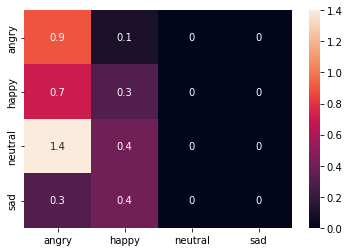

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Feb 2022

## Hamming Window

In [ ]:
def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr,window="hamming")
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,window="hamming")
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,window="hamming")
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,window="hamming")
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr,window="hamming")
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "TESS//train.csv"
test_csv = "TESS//test.csv"
val_csv = "TESS//val.csv"
csvpath = 'TESS//hamming_hand_engineered_features_EMODB_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'TESS//hamming_hand_engineered_features_EMODB_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'TESS//hamming_hand_engineered_features_EMODB_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:
csvpath = 'TESS/hamming_hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'TESS/hamming_hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'TESS/hamming_hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(1114, 26) (1114, 1)
(239, 26) (239, 1)
(239, 26) (239, 1)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('TESS//models//ensembled_hamming_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('TESS//models//ensembled_hamming_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
70/70 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.8106
Epoch 00001: val_loss improved from inf to 0.28772, saving model to TESS//models/ensembled_hamming_loss.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_accuracy improved from -inf to 0.95816, saving model to TESS//models/ensembled_hamming_acc.h5
70/70 [==============================] - 36s 265ms/step - loss: 0.7459 - accuracy: 0.8106 - val_loss: 0.2877 - val_accuracy: 0.9582
Epoch 2/30
70/70 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9803
Epoch 00002: val_loss improved from 0.28772 to 0.11334, saving model to TESS//models/ensembled_hamming_loss.h5

Epoch 00002: val_accuracy improved from 0.95816 to 0.97071, saving model to TESS//models/ensembled_hamming_acc.h5
70/70 [==============================] - 17s 246ms/step - loss: 0.1529 - accuracy: 0.9803 - val_loss: 0.1133 - val_accuracy: 0.9707
Epoch 3/30
70/70 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9892
Epoch 00003: val_loss improved from 0.11334 to 0.08232, saving model to TESS//models/ensembled_hamming_loss.h5

Epoch 00003: val_accuracy did not improve from 0.97071
70/70 [==============================] - 16

In [ ]:
ensembled.load_weights('TESS//models//ensembled_hamming_loss.h5')
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights('TESS//models//ensembled_hamming_acc.h5')
ensembled.evaluate([X_test,X_test_features],Y_test)

8/8 [==============================] - 2s 144ms/step - loss: 0.0189 - accuracy: 0.9958
[0.01888386905193329, 0.9958158731460571]
8/8 [==============================] - 1s 155ms/step - loss: 0.0223 - accuracy: 0.9874


[0.022274935618042946, 0.9874476790428162]

8/8 [==============================] - 1s 157ms/step - loss: 0.0223 - accuracy: 0.9874
[0.022274935618042946, 0.9874476790428162]
F1 SCORE: 0.987548878370035
Kappa: 0.9832433569375307
Accuracy: 0.9874476987447699
Jaccard Score: 0.975705329153605
Precision: 0.9878434065934066
Recall: 0.9873218201754386


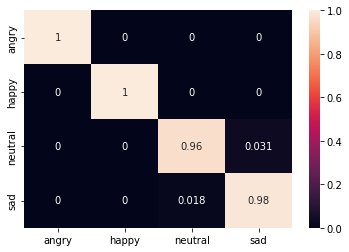

In [ ]:
ensembled.load_weights('TESS//models//ensembled_hamming_acc.h5')
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())